In [1]:
## FUNCTIONS FOR USING .DAT FILES FROM CW3E MET SITES FOR ANALYSIS
# By Hillary Beckmeyer (& nan_check fxn augmented from fxn by Ava Cooper)
# 25.AUG.2022
#
# SOME ALTERATIONS MAY BE NEEDED DEPENDENT ON WHAT ASPECTS OF THE DATA ARE BEING USED. THIS IS FOR TEMP (˚C), 
# RH (%), RAW BP (mb), MSLP (mb), WIND V1 (M/S), WIND MAX (M/S), 'SLR (W/M^2), PRECIP (mm), AND MIN BATTERY (V).
#
# ADDED ARE SOME FUNCTIONS FOR SOIL TEMP, PRESSURE, AND MOISTURE (AT DEPTHS OF 5CM, 10CM, 15CM, 20CM, 50CM, AND 100CM).
#
# CAN BE USED FOR GRAPHING VARIABLES AND COMPARATIVE ANALYSIS. ALSO FOR FINDING THE VARIABLES NEEDED FOR THE CLEARSKY
# CALCULATOR.


In [2]:
# IMPORTING PACKAGES THAT MAY BE NEEDED
%matplotlib inline
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.colors as colors
from matplotlib import cm, colors
import pandas as pd
import seaborn as sns
import pdb, sys, glob, os, shutil, netCDF4, argparse, csv

np.set_printoptions(suppress = True, formatter = {'float_kind':'{:0.2f}'.format})

In [3]:
# set root directory to surface met archive: THIS WILL BE WHEREVER SURF MET DATA LIVES ON YOUR COMPUTER
rd = "~/Downloads/CW3E_SurfaceMet_Archive/"

# THIS IS FOR SETTING THE DIRECTORY FOR ALL FILES (IF THEY'RE IN THE SAME FOLDER)
%cd $rd

/Users/hillarybeckmeyer/Downloads/CW3E_SurfaceMet_Archive


In [4]:
# FUNCTIONS FOR IMPORTING THE FILES AS A PANDAS DATAFRAME

def imp(file):
    f = pd.read_csv(file, sep = ',', header = None, index_col = 0, skiprows = 4, \
                    na_values = "NAN", keep_default_na = False, parse_dates = [0])
    print(f.shape)
    return f

# THERE WAS AN ERROR WITH THE HRD FILE BUT A QUICK FIX WAS TO SKIP THE FIRST 350,000 ROWS. ONLY USE IF YOU NEED
# MORE RECENT DATA AND DON'T HAVE THE TIME TO FIND THE ERRORS
def hrd(file):
    f = pd.read_csv(file, sep = ',', header = None, index_col = 0, skiprows = 350000, \
                    na_values = "NAN", keep_default_na = False, parse_dates = [0])
    print(f.shape)
    return f

# CHECKING THE TITLES W/ NO LABELS CUT OUT - NOT FOR GENERAL USE
def imp2(file):
    f = pd.read_csv(file, sep = ',', header = None, index_col = 0, skiprows = 1, \
                    na_values = "NAN", keep_default_na = False, parse_dates = [0])
    print(f.shape)
    return f

In [5]:
## FOR 2 MIN DATA:
## MAKING A NaN CHECK FXN TO FILL MISSING TIMESTAMPS & REDUCE # OF VARIABLES IN EACH DATAFRAME

# DEFINE FXN nan_check - TAKES 2 MIN DATAFRAME INPUT: SITE_FILE
def nan_check(SITE_FILE):
    
    # picking columns of interest
    use = SITE_FILE[[2,5,8,9,12,15,17,23,25]]
    # resample to 2 min (data are already 2 min so this fills in missing timestamps)
    met = use.resample('2T').mean()
    # rename columns
    met.columns = ['Temp (\N{degree sign}C)', 'RH (%)', 'Raw BP (mb)', 'BP MSL (mb)', 'Wnd V1', \
                       'Wnd max', 'SLR (W/m\N{superscript two})', 'PPT (mm)', 'Min Batt (V)']
    
    # count the # of NaNs per column
    nan_count = met.isnull().sum()
    
    # find the actual timestamps where any value in the dataframe is NaN
    ind = np.where(np.isnan(met))[0]
    
    # grab those timestamps from the data, drop repeated timestamps 
    # (occurs when multiple variables are NaN @ the same time)
    bad_idx = met.iloc[ind].index.drop_duplicates(keep = 'first')
    
    # fxn outputs 3 things: dataframe for entire time, array for bad index, & total count of NaNs per var
    return(met, bad_idx, nan_count)

In [6]:
## FOR SOIL DATA:
## MAKING A NaN CHECK FXN TO FILL MISSING TIMESTAMPS & REDUCE # OF VARIABLES IN EACH DATAFRAME

# DEFINE FXN nan_check - TAKES 2 MIN DATAFRAME INPUT: SITE_FILE
def nan_check_soil(SITE_FILE):
    
    # grab columns of interest
    use = SITE_FILE[[2,3,4,5,6,7,20,21,22,23,24,25,26,27,28,29,30,31]]
    # resample to 2 minutes (data are already 2 min so this fills in missing timestamps)
    met = use.resample('2T').mean()
    # rename columns
    met.columns = ['SoilTmp_5_C_Avg',  'SoilTmp_10_C_Avg', 'SoilTmp_15_C_Avg', 'SoilTmp_20_C_Avg', \
                       'SoilTmp_50_C_Avg','SoilTmp_100_C_Avg', 'PA_uS_5', 'PA_uS_10', 'PA_uS_15', \
                       'PA_uS_20', 'PA_uS_50', 'PA_uS_100', 'VWC_5', 'VWC_10', 'VWC_15', 'VWC_20', \
                       'VWC_50', 'VWC_100']
    
    # count the # of NaNs per column
    nan_count = met.isnull().sum()
    
    # find the actual timestamps where any value in the dataframe is NaN
    ind = np.where(np.isnan(met))[0]
    
    # grab those timestamps from the data, drop repeated timestamps 
    # (occurs when multiple variables are NaN @ the same time)
    bad_idx = met.iloc[ind].index.drop_duplicates(keep = 'first')
    
    # fxn outputs 3 things: dataframe for entire time, array for bad index, & total count of NaNs per var
    # will most likely only need the first output
    return(met, bad_idx, nan_count)

In [7]:
# SURFACE MET FILE UPLOAD: Use fxn to import file. 
# CUSTOMIZE SITE AND FILE_NAME BASED ON WHICH SITE(S) YOU ARE LOOKING AT.
#SITE = imp('FILE_NAME')

GPO = imp('GranitePortal_TwoMin.dat'            )
POR = imp('Portola_TwoMin.dat'                  )
BVS = imp('BrownsValleySchool_TwoMin.dat'       )
DLA = imp('CR1000X_Downieville_RF407_TwoMin.dat')
SKY = imp('Skyline_TwoMinWS.dat'                )
WPO = imp('CR1000X_WPO_TwoMin.dat'              )
WDG = imp('WindyGap_TwoMinWS.dat'               )
CAT = imp('CAT_CR1000X_TwoMin.dat'              )
NCM = imp('NorthCowMountain_TwoMinWS.dat'       )
LBH = imp('LowerBathHouse_TwoMin.dat'           )
FRC = imp('FeatherRiverCollege_TwoMin.dat'      )
BCC = imp('BoyesCreekCanyon_TwoMinWS 2.dat'     )
NBB = imp('CR1000X_NBB_radio_TwoMin.dat'        )
HDC = imp('HellsDelight_TwoMinWS.dat'           )
PVN = imp('PotterValleyNorth_TwoMinWS.dat'      )
HRD = hrd('CR1000X_HRD_Radio_TwoMin.dat'        )
DRW = hrd('Deerwood_TwoMinWS.dat'               )
SOD = hrd('CR1000X_SOD_TwoMin.dat'              )

(43228, 27)
(154032, 27)
(305223, 27)
(706965, 27)
(696106, 27)
(247508, 27)
(1033996, 27)
(616755, 27)
(1032819, 27)
(200147, 27)
(732692, 27)
(968784, 27)
(708184, 27)
(922978, 27)
(987355, 27)
(72523, 27)
(683644, 27)
(234504, 27)


In [8]:
# SOIL FILE UPLOAD: Use fxn to import file.

# CUSTOMIZE SITE AND FILE_NAME BASED ON WHICH SITE(S) YOU ARE LOOKING AT.
# I like to differentiate by adding an "S" to the end of the dataframe name if it is a soil file vs. a surf. met. one.
# That way, if I'm using both, it's easy to differentiate.

#SITE_S = imp('FILE_NAME')

In [9]:
# SURFACE MET DATA: Edit depending on the sites you are looking at, or skip if only viewing one site
site_list = [BCC, BVS, CAT, DRW, DLA, FRC, GPO, HDC, HRD, LBH, NBB, NCM, POR, PVN, SKY, SOD, WDG, WPO]
site_name = ['BCC', 'BVS', 'CAT', 'DRW', 'DLA', 'FRC', 'GPO', 'HDC', 'HRD', 'LBH', 'NBB', 'NCM', 'POR', \
              'PVN', 'SKY', 'SOD', 'WDG', 'WPO']

mets, badidxs, nans = [], [], []
for x in range(len(site_list)):
    met, badidx, nan = nan_check(site_list[x])
    mets.append(met), badidxs.append(badidx), nans.append(nan)

for x in range(len(mets)):
    mets[x].index.rename(site_name[x], inplace = True)

In [10]:
for i in range(len(mets)):
    print(mets[i].index.name)

BCC
BVS
CAT
DRW
DLA
FRC
GPO
HDC
HRD
LBH
NBB
NCM
POR
PVN
SKY
SOD
WDG
WPO


In [11]:
# SURFACE MET DATA: If just looking at a singular site, and changing index name to 'Time'
#SITE_met, SITE_badidx, SITE_nan = nan_check(SITE)
#SITE_met.index.rename('Time', inplace = True)

WDG_met, WDG_badidx, WDG_nan = nan_check(WDG)
WDG_met.index.rename('Time', inplace = True)

NCM_met, NCM_badidx, NCM_nan = nan_check(NCM)
NCM_met.index.rename('Time', inplace = True)

HDC_met, HDC_badidx, HDC_nan = nan_check(HDC)
HDC_met.index.rename('Time', inplace = True)

DLA_met, DLA_badidx, DLA_nan = nan_check(DLA)
DLA_met.index.rename('Time', inplace = True)

SKY_met, SKY_badidx, SKY_nan = nan_check(SKY)
SKY_met.index.rename('Time', inplace = True)

FRC_met, FRC_badidx, FRC_nan = nan_check(FRC)
FRC_met.index.rename('Time', inplace = True)

DRW_met, DRW_badidx, DRW_nan = nan_check(DRW)
DRW_met.index.rename('Time', inplace = True)

In [12]:
# SOIL DATA: Apply nan_check_soil fxn to site and change index name to 'Time'
#SITE_met, SITE_badidx, SITE_nan = nan_check_soil(SITE)
#SITE_met.index.rename('Time', inplace = True)

In [13]:
## RENAMING THE VARIABLES TO SIMPLIFY
# surface met vars
tp, rh, bp, msl, v1, wmax, sr, ppt, batt = 'Temp (\N{degree sign}C)', 'RH (%)', 'Raw BP (mb)', 'BP MSL (mb)', \
    'Wnd V1', 'Wnd max', 'SLR (W/m\N{superscript two})', 'PPT (mm)', 'Min Batt (V)'

# Soil vars
t5, t10, t15, t20, t50, t100, p5, p10, p15, p20, p50, p100, m5, m10, m15, m20, m50, m100 = 'SoilTmp_5_C_Avg',  \
    'SoilTmp_10_C_Avg', 'SoilTmp_15_C_Avg', 'SoilTmp_20_C_Avg','SoilTmp_50_C_Avg','SoilTmp_100_C_Avg', 'PA_uS_5',\
    'PA_uS_10', 'PA_uS_15','PA_uS_20', 'PA_uS_50', 'PA_uS_100','VWC_5', 'VWC_10', 'VWC_15', 'VWC_20', \
    'VWC_50', 'VWC_100'

## PUTTING VARIABLES INTO LIST
#impvals = most important vals for ClearSky model
impvals = [tp, rh, sr]
vals    = [tp, rh, bp, msl, v1, wmax, sr, ppt, batt]

# Separating soil vars by type
soil_temp     = [t5, t10, t15, t20, t50, t100] 
soil_p        = [p5, p10, p15, p20, p50, p100]
soil_moisture = [m5, m10, m15, m20, m50, m100]

In [14]:
# Fxn to plot any list of soil variables

def allSoil(site, types, word, loc):
    plt.rcParams["figure.figsize"] = [20.00, 8.0]
    plt.rcParams["figure.autolayout"] = True
    fig, ax = plt.subplots(1)
    fig.autofmt_xdate()
    # run through list of depths, if wanting to plot multiple vars
    for i in range(len(types)): 
        plt.plot(site[types[i]], label = types[i])
    plt.xlabel('Date', fontweight = 'bold', fontsize = 16)
    plt.ylabel(word, fontweight = 'bold', fontsize = 16)
    # can change ymin and ymax depending on season or scope 
    ax.set_ylim(ymin = 0, ymax = 45)
    xfmt = mdates.DateFormatter('%D')
    ax.xaxis.set_major_formatter(xfmt)
    plt.title(word+loc, fontweight = 'bold', fontsize = '20')
    plt.legend(loc = 'upper left')
    plt.show()

# Fxn specifying soil temp
def allTemp(site, loc):
    allSoil(site, soil_temp, 'Soil Temp (\N{degree sign}C)', loc) 
    # allSoil(site, soil_temp[0:1], 'Soil Temp (\N{degree sign}C)', loc) 
    
# Fxn specifying soil moisture
def allMoisture(site, loc):
    allSoil(site, soil_moisture, 'Soil Moisture', loc) 
    # allSoil(site, soil_moisture[0:1], 'Soil Moisture', loc) 

In [16]:
ticky = np.arange(0, 1300, step = 100)

# Fxn to plot variables over a span of time
def VARday(var, kind, words):
    sns.set_theme(style = "ticks", font_scale = 1.25)
    sns.despine(offset = 10, trim = True)
    ax = plt.gca()
    var[kind].plot(color = 'm', figsize = (15,4))
    plt.title(str(kind)+': '+words)
    plt.xlabel('Date')
    plt.ylabel(kind)
    ax.set_ylim(ymin = 0, ymax = 1200)
    plt.yticks(ticky)
    plt.show()

# Fxn specifying solar rad to plot
def SLR(var, words):
    VARday(var, sr, words)
    
def graphALL(site, v):
    for x in range(len(site)):
        VARday((site[x])[v], v, str())
    
def allSLR(var):
    for i in range(len(var)):
        SLR((var[i]), str(var[i].index.date[0]))
    
#finding the maximum value of a variable for a specified timeframe
def maxVAR(var):    
    var_day = var
    h = var_day.shape[0]
    
    high = 0
    time_x = 0
    
    for x in range(h):
        if(var[x] > high):
            high = var[x]
            time_x = var.index[x]
            hour_x = var.index.time[x]
            date_x = var.index.date[x]
        else:
            continue
            
    return high, time_x, hour_x, date_x

# Fxn printing the maximum date, time, and value of a variable
def prntMAX(var, num, end):
    high, time_x, hour_x, date_x = maxVAR(var)
    print('Peak', str((GPO_met.columns)[num]), 'is on', date_x, 'at', hour_x, 'UTC:', high, end)
    return high, time_x, hour_x, date_x

# Fxn specifying solar rad as the variable to print
def solar(var):
    maxi, ind, hour, date = prntMAX(var, 6, 'W/m\N{superscript two}')
    return maxi, ind, hour, date
    
# Fxn finding the other variable quantities at max solar rad time
def allVAR(var, loc):
    h = len(loc.columns)
    high, time_x, hour_x, date_x = maxVAR(var)
    print(time_x,'\n')
    vals = np.array([], dtype = np.float64)
    x = 0
    for col in loc.columns: 
        if x < h:
            b = loc.columns[x]
            vals = np.append(vals, loc[b][time_x])
            print(b, ':', loc[b][time_x])
            x += 1
        else:
            break;
            
    print('\n')
    return vals

def clearsky(site, kind, vals):
    A, B, C, D, E, F, G, H, I, J, K = np.array([]), np.array([]), np.array([]), np.array([]), \
    np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    Z = ()
    for q in range(len(site)):
        a = (site[q])[kind].max()
        b = (site[q])[kind].idxmax()
        A = np.append(A, a)
        B = np.append(B, b)
        print('\n')
        print(b)
        for r in range(len(vals)):
            print(vals[r], '=', (site[q])[vals[r]][b])
            if vals[r] == 'Temp (\N{degree sign}C)':
                c = (site[q])[vals[r]][b]
                C = np.append(C, c)
            elif vals[r] == 'RH (%)':
                d = (site[q])[vals[r]][b]
                D = np.append(D, d) 
            elif vals[r] == 'Raw BP (mb)':
                e = (site[q])[vals[r]][b]
                E = np.append(E, e)
            elif vals[r] == 'BP MSL (mb)':
                f = (site[q])[vals[r]][b]
                F = np.append(F, f)
            elif vals[r] == 'Wnd V1':
                g = (site[q])[vals[r]][b]
                G = np.append(G, g)
            elif vals[r] == 'Wnd max':
                h = (site[q])[vals[r]][b]
                H = np.append(H, h)
            elif vals[r] == 'SLR (W/m\N{superscript two})':
                i = (site[q])[vals[r]][b]
                I = np.append(I, i)
            elif vals[r] == 'PPT (mm)':
                j = (site[q])[vals[r]][b]
                J = np.append(J, j)
            elif vals[r] == 'Min Batt (V)':
                k = (site[q])[vals[r]][b]
                K = np.append(K, k)
            else:
                break
        Z = (A, B, C, D, E, F, G, H, I, J, K)
    return(Z)

def csky(site):
    x = clearsky(site, sr, impvals)
    return(x)

In [17]:
#Set fxn timespans to ranges you'd like to look at
def groups(site):
    A = site["2022-04-01 07:00":"2022-04-10 07:00"][sr]
    B = site["2022-04-10 7:00":"2022-04-20 07:00"][sr]
    C = site["2022-04-20 7:00":"2022-04-30 07:00"][sr]
    D = site["2022-04-30 7:00":"2022-05-09 07:00"][sr]
    G = [A, B, C, D]
    return(G)

def foursome(group):
    for i in range(len(group)):
        SLR(group[i], ' from '+str(group[i].index.date[0])+' to '+str(group[i].index.date[-1]))

In [18]:
## Pick specific dates and times you would like to look at for each site
print(mets[6].index.name)

gpo_whole = mets[6]
gpo_set = mets[6]["2022-04-01 07:00":"2022-05-09 18:02"]

gpo0    = mets[6]['2022-04-01 13:00':'2022-04-02 03:00']
gpo1    = mets[6]['2022-04-05 13:00':'2022-04-06 03:00']
gpo2    = mets[6]['2022-04-06 13:00':'2022-04-07 03:00']
gpo3    = mets[6]['2022-04-09 13:00':'2022-04-10 03:00']
gpo4    = mets[6]['2022-04-17 13:00':'2022-04-18 03:00']
gpo5    = mets[6]['2022-04-25 13:00':'2022-04-26 03:00']
gpo6    = mets[6]['2022-04-28 13:00':'2022-04-29 03:00']
gpo7    = mets[6]['2022-04-30 13:00':'2022-05-01 03:00']
gpo8    = mets[6]['2022-05-01 13:00':'2022-05-02 03:00']
gpo9    = mets[6]['2022-05-03 13:00':'2022-05-04 03:00']
gpo10   = mets[6]['2022-05-04 13:00':'2022-05-05 03:00']

# Making a list combining all the days and the name of the site will come in handy down the line.
gpox = [gpo0, gpo1, gpo2, gpo3, gpo4, gpo5, gpo6, gpo7, gpo8, gpo9, gpo10]
gpoz = [mets[6].index.name, "Granite Portal", gpox]

GPO


In [19]:
## Pick specific dates and times you would like to look at for each site

print(mets[12].index.name)

por_whole = mets[12]
por_set = mets[12]['2022-04-01 07:00':'2022-05-09 18:02']

por0    = mets[12]['2022-04-01 13:00':'2022-04-02 03:00']
por1    = mets[12]['2022-04-05 13:00':'2022-04-06 03:00']
por2    = mets[12]['2022-04-06 13:00':'2022-04-07 03:00']
por3    = mets[12]['2022-04-09 13:00':'2022-04-10 03:00']
por4    = mets[12]['2022-04-17 13:00':'2022-04-18 03:00']
por5    = mets[12]['2022-04-18 13:00':'2022-04-19 03:00']
por6    = mets[12]['2022-04-24 13:00':'2022-04-25 03:00']
por7    = mets[12]['2022-04-27 13:00':'2022-04-28 03:00']
por8    = mets[12]['2022-05-01 13:00':'2022-05-02 03:00']
por9    = mets[12]['2022-05-03 13:00':'2022-05-04 03:00']
por10   = mets[12]['2022-05-04 13:00':'2022-05-05 03:00']

porx = [por0, por1, por2, por3, por4, por5, por6, por7, por8, por9, por10]
porz = [mets[12].index.name, "Portola", porx]

POR


In [20]:
## Pick specific dates and times you would like to look at for each site

print(mets[1].index.name)

bvs_whole = mets[1]
bvs_set   = mets[1]["2022-04-01 07:00":"2022-05-09 18:02"]

bvs0      = mets[1]['2022-04-01 13:00':'2022-04-02 03:00']
bvs1      = mets[1]['2022-04-05 13:00':'2022-04-06 03:00']
bvs2      = mets[1]['2022-04-06 13:00':'2022-04-07 03:00']
bvs3      = mets[1]['2022-04-09 13:00':'2022-04-10 03:00']
bvs4      = mets[1]['2022-04-17 13:00':'2022-04-18 03:00']
bvs5      = mets[1]['2022-04-23 13:00':'2022-04-24 03:00']
bvs6      = mets[1]['2022-04-26 13:00':'2022-04-27 03:00']
bvs7      = mets[1]['2022-04-28 13:00':'2022-04-29 03:00']
bvs8      = mets[1]['2022-05-01 13:00':'2022-05-02 03:00']
bvs9      = mets[1]['2022-05-03 13:00':'2022-05-04 03:00']
bvs10     = mets[1]['2022-05-04 13:00':'2022-05-05 03:00']

bvsx = [bvs0, bvs1, bvs2, bvs3, bvs4, bvs5, bvs6, bvs7, bvs8, bvs9, bvs10]
bvsz = [mets[1].index.name, "Browns Valley School", bvsx]

BVS


In [21]:
## Pick specific dates and times you would like to look at for each site

print(mets[4].index.name)

dla_whole = mets[4]
dla_set = mets[4]["2022-04-01 07:00":"2022-05-09 18:02"]

dla0    = mets[4]['2022-04-01 13:00':'2022-04-02 03:00']
dla1    = mets[4]['2022-04-05 13:00':'2022-04-06 03:00']
dla2    = mets[4]['2022-04-06 13:00':'2022-04-07 03:00']
dla3    = mets[4]['2022-04-09 13:00':'2022-04-10 03:00']
dla4    = mets[4]['2022-04-17 13:00':'2022-04-18 03:00']
dla5    = mets[4]['2022-04-24 13:00':'2022-04-25 03:00']
dla6    = mets[4]['2022-05-01 13:00':'2022-05-02 03:00']
dla7    = mets[4]['2022-05-03 13:00':'2022-05-04 03:00']
dla8    = mets[4]['2022-05-04 13:00':'2022-05-05 03:00']

dlax = [dla0, dla1, dla2, dla3, dla4, dla5, dla6, dla7, dla8]
dlaz = [mets[4].index.name, "Downieville", dlax]

DLA


In [22]:
## Pick specific dates and times you would like to look at for each site

print(mets[14].index.name)

sky_whole = mets[14]
sky_set   = mets[14]["2022-04-01 07:00":"2022-05-09 18:02"]

sky0      = mets[14]['2022-04-01 13:00':'2022-04-02 03:00']
sky1      = mets[14]['2022-04-02 13:00':'2022-04-03 03:00']
sky2      = mets[14]['2022-04-05 13:00':'2022-04-06 03:00']
sky3      = mets[14]['2022-04-06 13:00':'2022-04-07 03:00']
sky4      = mets[14]['2022-04-17 13:00':'2022-04-18 03:00']
sky5      = mets[14]['2022-04-23 13:00':'2022-04-24 03:00']
sky6      = mets[14]['2022-04-26 13:00':'2022-04-27 03:00']
sky7      = mets[14]['2022-04-27 13:00':'2022-04-28 03:00']
sky8      = mets[14]['2022-05-01 13:00':'2022-05-02 03:00']
sky9      = mets[14]['2022-05-03 13:00':'2022-05-04 03:00']
sky10     = mets[14]['2022-05-04 13:00':'2022-05-05 03:00']

skyx = [sky0, sky1, sky2, sky3, sky4, sky5, sky6, sky7, sky8, sky9, sky10]
skyz = [mets[14].index.name, "Skyline Harvest", skyx]

SKY


In [23]:
## Pick specific dates and times you would like to look at for each site

print(mets[-1].index.name)

wpo_whole = mets[-1]
wpo_set   = mets[-1]["2022-04-01 07:00":"2022-05-09 18:02"]

wpo0      = mets[-1]['2022-04-01 13:00':'2022-04-02 03:00']
wpo1      = mets[-1]['2022-04-05 13:00':'2022-04-06 03:00']
wpo2      = mets[-1]['2022-04-06 13:00':'2022-04-07 03:00']
wpo3      = mets[-1]['2022-04-09 13:00':'2022-04-10 03:00']
wpo4      = mets[-1]['2022-04-12 13:00':'2022-04-13 03:00']
wpo5      = mets[-1]['2022-04-17 13:00':'2022-04-18 03:00']
wpo6      = mets[-1]['2022-04-23 13:00':'2022-04-24 03:00']
wpo7      = mets[-1]['2022-04-28 13:00':'2022-04-29 03:00']
wpo8      = mets[-1]['2022-05-01 13:00':'2022-05-02 03:00']
wpo9      = mets[-1]['2022-05-03 13:00':'2022-05-04 03:00']
wpo10     = mets[-1]['2022-05-04 13:00':'2022-05-05 03:00']

wpox = [wpo0, wpo1, wpo2, wpo3, wpo4, wpo5, wpo6, wpo7, wpo8, wpo9, wpo10]
wpoz = [mets[-1].index.name, "West Portal", wpox]

WPO


In [24]:
## Pick specific dates and times you would like to look at for each site

print(mets[-2].index.name)

wdg_whole = mets[-2]
wdg_set   = mets[-2]["2022-04-01 07:00":"2022-05-09 18:02"]

wdg0      = mets[-2]['2022-04-05 13:00':'2022-04-06 03:00']
wdg1      = mets[-2]['2022-04-06 13:00':'2022-04-07 03:00']
wdg2      = mets[-2]['2022-04-09 13:00':'2022-04-10 03:00']
wdg3      = mets[-2]['2022-04-17 13:00':'2022-04-18 03:00']
wdg4      = mets[-2]['2022-04-23 13:00':'2022-04-24 03:00']
wdg5      = mets[-2]['2022-04-24 13:00':'2022-04-25 03:00']
wdg6      = mets[-2]['2022-04-26 13:00':'2022-04-27 03:00']
wdg7      = mets[-2]['2022-04-27 13:00':'2022-04-28 03:00']
wdg8      = mets[-2]['2022-05-01 13:00':'2022-05-02 03:00']
wdg9      = mets[-2]['2022-05-03 13:00':'2022-05-04 03:00']
wdg10     = mets[-2]['2022-05-04 13:00':'2022-05-05 03:00']

wdgx = [wdg0, wdg1, wdg2, wdg3, wdg4, wdg5, wdg6, wdg7, wdg8, wdg9, wdg10]
wdgz = [mets[-2].index.name, "Windy Gap", wdgx]

WDG


In [25]:
## Pick specific dates and times you would like to look at for each site

print(mets[8].index.name)

hrd_whole = mets[8]
hrd_set   = mets[8]["2022-04-01 07:00":"2022-05-09 18:02"]

hrd0      = mets[8]['2022-04-05 13:00':'2022-04-06 03:00']
hrd1      = mets[8]['2022-04-06 13:00':'2022-04-07 03:00']
hrd2      = mets[8]['2022-04-08 13:00':'2022-04-09 03:00']
hrd3      = mets[8]['2022-04-09 13:00':'2022-04-10 03:00']
hrd4      = mets[8]['2022-04-12 13:00':'2022-04-12 21:00']
hrd5      = mets[8]['2022-04-17 13:00':'2022-04-18 03:00']
hrd6      = mets[8]['2022-04-23 13:00':'2022-04-24 03:00']
hrd7      = mets[8]['2022-04-28 13:00':'2022-04-29 03:00']
hrd8      = mets[8]['2022-05-01 13:00':'2022-05-01 20:40']
hrd9      = mets[8]['2022-05-03 13:00':'2022-05-04 03:00']
hrd10     = mets[8]['2022-05-04 13:00':'2022-05-05 03:00']

hrdx = [hrd0, hrd1, hrd2, hrd3, hrd4, hrd5, hrd6, hrd7, hrd8, hrd9, hrd10]
hrdz = [mets[8].index.name, "Henness Ridge Drive", hrdx]

HRD


In [26]:
## Pick specific dates and times you would like to look at for each site

print(mets[2].index.name)

cat_whole = mets[2]
cat_set   = mets[2]["2022-04-01 07:00":"2022-05-09 18:02"]

cat0      = mets[2]['2022-04-06 13:00':'2022-04-07 03:00']
cat1      = mets[2]['2022-04-07 13:00':'2022-04-08 03:00']
cat2      = mets[2]['2022-04-08 13:00':'2022-04-09 03:00']
cat3      = mets[2]['2022-04-12 13:00':'2022-04-13 03:00']
cat4      = mets[2]['2022-04-13 13:00':'2022-04-14 03:00']
cat5      = mets[2]['2022-04-23 13:00':'2022-04-24 03:00']
cat6      = mets[2]['2022-04-24 13:00':'2022-04-25 03:00']
cat7      = mets[2]['2022-04-25 13:00':'2022-04-26 03:00']
cat8      = mets[2]['2022-04-30 13:00':'2022-05-01 03:00']
cat9      = mets[2]['2022-05-04 13:00':'2022-05-05 03:00']
cat10     = mets[2]['2022-05-06 13:00':'2022-05-07 03:00']

catx = [cat0, cat1, cat2, cat3, cat4, cat5, cat6, cat7, cat8, cat9, cat10]
catz = [mets[2].index.name, "Catalina", catx]

CAT


In [27]:
## Pick specific dates and times you would like to look at for each site

print(mets[3].index.name)

drw_whole = mets[3]

drw0      = mets[3]['2022-04-01 13:00':'2022-04-02 03:00']
drw1      = mets[3]['2022-04-05 13:00':'2022-04-06 03:00']
drw2      = mets[3]['2022-04-06 13:00':'2022-04-07 03:00']
drw3      = mets[3]['2022-04-09 13:00':'2022-04-10 03:00']
drw4      = mets[3]['2022-04-17 13:00':'2022-04-18 03:00']
drw5      = mets[3]['2022-04-24 13:00':'2022-04-25 03:00']
drw6      = mets[3]['2022-04-26 13:00':'2022-04-27 03:00']
drw7      = mets[3]['2022-04-27 13:00':'2022-04-28 03:00']
drw8      = mets[3]['2022-05-01 13:00':'2022-05-02 03:00']
drw9      = mets[3]['2022-05-03 13:00':'2022-05-04 03:00']
drw10     = mets[3]['2022-05-04 13:00':'2022-05-05 03:00']
drw_set   = mets[3]["2022-04-01 07:00":"2022-05-09 18:02"]

drwx = [drw0, drw1, drw2, drw3, drw4, drw5, drw6, drw7, drw8, drw9, drw10]
drwz = [mets[3].index.name, "Deerwood", drwx]

DRW


In [28]:
## Pick specific dates and times you would like to look at for each site

print(mets[11].index.name)

ncm_whole = mets[11]
ncm_set   = mets[11]["2022-04-01 07:00":"2022-05-09 18:02"]

ncm0      = mets[11]['2022-04-01 13:00':'2022-04-02 03:00']
ncm1      = mets[11]['2022-04-05 13:00':'2022-04-06 03:00']
ncm2      = mets[11]['2022-04-06 13:00':'2022-04-07 03:00']
ncm3      = mets[11]['2022-04-09 13:00':'2022-04-10 03:00']
ncm4      = mets[11]['2022-04-17 13:00':'2022-04-18 03:00']
ncm5      = mets[11]['2022-04-23 13:00':'2022-04-24 03:00']
ncm6      = mets[11]['2022-04-24 13:00':'2022-04-25 03:00']
ncm7      = mets[11]['2022-04-27 13:00':'2022-04-28 03:00']
ncm8      = mets[11]['2022-05-01 13:00':'2022-05-02 03:00']
ncm9      = mets[11]['2022-05-03 13:00':'2022-05-04 03:00']
ncm10     = mets[11]['2022-05-04 13:00':'2022-05-05 03:00']

ncmx = [ncm0, ncm1, ncm2, ncm3, ncm4, ncm5, ncm6, ncm7, ncm8, ncm9, ncm10]
ncmz = [mets[11].index.name, "North Cow Mountain", ncmx]

NCM


In [29]:
## Pick specific dates and times you would like to look at for each site

print(mets[9].index.name)

lbh_whole = mets[9]
lbh_set   = mets[9]['2021-05-01 13:00':'2021-06-01 03:00']

lbh0      = mets[9]['2021-05-01 13:00':'2021-05-02 03:00']
lbh1      = mets[9]['2021-05-03 13:00':'2021-05-04 03:00']
lbh2      = mets[9]['2021-05-04 13:00':'2021-05-05 03:00']
lbh3      = mets[9]['2021-05-05 13:00':'2021-05-06 03:00']
lbh4      = mets[9]['2021-05-07 13:00':'2021-05-08 03:00']
lbh5      = mets[9]['2021-05-08 13:00':'2021-05-09 03:00']
lbh6      = mets[9]['2021-05-10 13:00':'2021-05-11 03:00']
lbh7      = mets[9]['2021-05-11 13:00':'2021-05-12 03:00']
lbh8      = mets[9]['2021-05-12 13:00':'2021-05-13 03:00']
lbh9      = mets[9]['2021-05-13 13:00':'2021-05-14 03:00']
lbh10     = mets[9]['2021-05-30 13:00':'2021-05-31 03:00']

lbhx = [lbh0, lbh1, lbh2, lbh3, lbh4, lbh5, lbh6, lbh7, lbh8, lbh9, lbh10]
lbhz = [mets[9].index.name, "Lower Bathhouse", lbhx]

LBH


In [30]:
lbhA = mets[9]["2021-04-21 07:00":"2021-05-01 07:00"][sr]
lbhB = mets[9]["2021-05-01 07:00":"2021-05-11 07:00"][sr] 
lbhC = mets[9]["2021-05-11 07:00":"2021-05-21 07:00"][sr] 
lbhD = mets[9]["2021-05-21 07:00":"2021-05-31 07:00"][sr] 

lbhG = [lbhA, lbhB, lbhC, lbhD]

In [31]:
## Pick specific dates and times you would like to look at for each site

print(mets[5].index.name)

frc_whole = mets[5]
frc_set   = mets[5]["2022-05-01 07:00":"2022-06-04 18:02"]

frc0      = mets[5]['2022-05-01 13:00':'2022-05-02 03:00']
frc1      = mets[5]['2022-05-03 13:00':'2022-05-04 03:00']
frc2      = mets[5]['2022-05-04 13:00':'2022-05-05 03:00']
frc3      = mets[5]['2022-05-17 13:00':'2022-05-18 03:00']
frc4      = mets[5]['2022-05-19 13:00':'2022-05-20 03:00']
frc5      = mets[5]['2022-05-20 13:00':'2022-05-21 03:00']
frc6      = mets[5]['2022-05-22 13:00':'2022-05-23 03:00']
frc7      = mets[5]['2022-05-23 13:00':'2022-05-24 03:00']
frc8      = mets[5]['2022-05-24 13:00':'2022-05-25 03:00']
frc9      = mets[5]['2022-05-25 13:00':'2022-05-26 03:00']
frc10     = mets[5]['2022-05-31 13:00':'2022-06-01 03:00']

frcx = [frc0, frc1, frc2, frc3, frc4, frc5, frc6, frc7, frc8, frc9, frc10]
frcz = [mets[5].index.name, "Feather River College", frcx]

FRC


In [32]:
frcA = mets[5]["2022-05-01 07:00":"2022-05-10 07:00"][sr]
frcB = mets[5]["2022-05-10 07:00":"2022-05-20 07:00"][sr]
frcC = mets[5]["2022-05-20 07:00":"2022-05-30 07:00"][sr]
frcD = mets[5]["2022-05-30 07:00":"2022-06-09 07:00"][sr]
frcG = [frcA, frcB, frcC, frcD]

In [33]:
## Pick specific dates and times you would like to look at for each site

print(mets[0].index.name)

bcc_whole = mets[0]
bcc_set   = mets[0]["2022-04-01 07:00":"2022-05-09 18:02"]

bcc0      = mets[0]['2022-04-01 13:00':'2022-04-02 03:00']
bcc1      = mets[0]['2022-04-05 13:00':'2022-04-06 03:00']
bcc2      = mets[0]['2022-04-06 13:00':'2022-04-07 03:00']
bcc3      = mets[0]['2022-04-17 13:00':'2022-04-18 03:00']
bcc4      = mets[0]['2022-04-24 13:00':'2022-04-25 03:00']
bcc5      = mets[0]['2022-04-26 13:00':'2022-04-27 03:00']
bcc6      = mets[0]['2022-04-27 13:00':'2022-04-28 03:00']
bcc7      = mets[0]['2022-04-28 13:00':'2022-04-29 03:00']
bcc8      = mets[0]['2022-05-01 13:00':'2022-05-02 03:00']
bcc9      = mets[0]['2022-05-03 13:00':'2022-05-04 03:00']
bcc10     = mets[0]['2022-05-04 13:00':'2022-05-05 03:00']

bcc_whole = mets[0]["2022-04-01 07:00":"2022-07-07 00:00"]

bccx = [bcc0, bcc1, bcc2, bcc3, bcc4, bcc5, bcc6, bcc7, bcc8, bcc9, bcc10]
bccz = [mets[0].index.name, "Boyes Creek Canyon", bccx]

BCC


In [34]:
## Pick specific dates and times you would like to look at for each site

print(mets[10].index.name)

nbb_whole = mets[10]
nbb_set   = mets[10]["2022-04-01 07:00":"2022-05-09 18:02"]

nbb0      = mets[10]['2022-04-01 13:00':'2022-04-02 03:00']
nbb1      = mets[10]['2022-04-05 13:00':'2022-04-06 03:00']
nbb2      = mets[10]['2022-04-06 13:00':'2022-04-07 03:00']
nbb3      = mets[10]['2022-04-09 13:00':'2022-04-10 03:00']
nbb4      = mets[10]['2022-04-17 13:00':'2022-04-18 03:00']
nbb5      = mets[10]['2022-04-23 13:00':'2022-04-24 03:00']
nbb6      = mets[10]['2022-04-24 13:00':'2022-04-25 03:00']
nbb7      = mets[10]['2022-04-26 13:00':'2022-04-27 03:00']
nbb8      = mets[10]['2022-05-01 13:00':'2022-05-02 03:00']
nbb9      = mets[10]['2022-05-03 13:00':'2022-05-04 03:00']
nbb10     = mets[10]['2022-05-04 13:00':'2022-05-05 03:00']

nbbx = [nbb0, nbb1, nbb2, nbb3, nbb4, nbb5, nbb6, nbb7, nbb8, nbb9, nbb10]
nbbz = [mets[10].index.name, "New Bullards Bar Dam", nbbx]

NBB


In [35]:
## Pick specific dates and times you would like to look at for each site

print(mets[-3].index.name)

sod_whole = mets[-3]
sod_set   = mets[-3]["2022-04-01 07:00":"2022-05-09 18:02"]

sod0      = mets[-3]['2022-04-05 13:00':'2022-04-06 03:00']
sod1      = mets[-3]['2022-04-06 13:00':'2022-04-07 03:00']
sod2      = mets[-3]['2022-04-07 13:00':'2022-04-08 03:00']
sod3      = mets[-3]['2022-04-12 13:00':'2022-04-13 03:00']
sod4      = mets[-3]['2022-04-13 13:00':'2022-04-14 03:00']
sod5      = mets[-3]['2022-04-14 13:00':'2022-04-15 03:00']
sod6      = mets[-3]['2022-04-15 13:00':'2022-04-16 03:00']
sod7      = mets[-3]['2022-04-29 13:00':'2022-04-30 03:00']
sod8      = mets[-3]['2022-05-01 13:00':'2022-05-02 03:00']
sod9      = mets[-3]['2022-05-02 13:00':'2022-05-03 03:00']
sod10     = mets[-3]['2022-05-04 13:00':'2022-05-05 03:00']

sodx = [sod0, sod1, sod2, sod3, sod4, sod5, sod6, sod7, sod8, sod9, sod10]
sodz = [mets[-3].index.name, "Seven Oaks Dam", sodx]

SOD


In [36]:
## Pick specific dates and times you would like to look at for each site

print(mets[7].index.name)

hdc_whole = mets[7]
hdc_set   = mets[7]["2022-06-03 07:00":"2022-07-07 00:00"]

hdc0      = mets[7]['2022-06-06 13:00':'2022-06-07 03:00']
hdc1      = mets[7]['2022-06-13 13:00':'2022-06-14 03:00']
hdc2      = mets[7]['2022-06-14 13:00':'2022-06-15 03:00']
hdc3      = mets[7]['2022-06-20 13:00':'2022-06-21 03:00']
hdc4      = mets[7]['2022-06-21 13:00':'2022-06-22 03:00']
hdc5      = mets[7]['2022-06-25 13:00':'2022-06-26 03:00']
hdc6      = mets[7]['2022-06-26 13:00':'2022-06-27 03:00']
hdc7      = mets[7]['2022-06-28 13:00':'2022-06-29 03:00']
hdc8      = mets[7]['2022-06-29 13:00':'2022-06-30 03:00']
hdc9      = mets[7]['2022-06-30 13:00':'2022-07-01 03:00']
hdc10     = mets[7]['2022-07-01 13:00':'2022-07-02 03:00']

hdcx = [hdc0, hdc1, hdc2, hdc3, hdc4, hdc5, hdc6, hdc7, hdc8, hdc9, hdc10]
hdcz = [mets[7].index.name, "Hell's Delight Canyon", hdcx]

HDC


In [37]:
hdcA = mets[7]["2022-06-03 07:00":"2022-06-10 07:00"][sr]
hdcB = mets[7]["2022-06-10 07:00":"2022-06-20 07:00"][sr]
hdcC = mets[7]["2022-06-20 07:00":"2022-06-30 07:00"][sr]
hdcD = mets[7]["2022-06-30 07:00":"2022-07-06 07:00"][sr]
hdcG = [hdcA, hdcB, hdcC, hdcD]

In [38]:
## Pick specific dates and times you would like to look at for each site

print(mets[-5].index.name)

pvn_whole = mets[-5]
pvn_set   = mets[-5]["2022-06-03 07:00":"2022-07-07 00:00"]

pvn0      = mets[-5]['2022-04-01 13:00':'2022-04-02 03:00']
pvn1      = mets[-5]['2022-04-05 13:00':'2022-04-06 03:00']
pvn2      = mets[-5]['2022-04-06 13:00':'2022-04-07 03:00']
pvn3      = mets[-5]['2022-04-09 13:00':'2022-04-10 03:00']
pvn4      = mets[-5]['2022-04-17 13:00':'2022-04-18 03:00']
pvn5      = mets[-5]['2022-04-24 13:00':'2022-04-25 03:00']
pvn6      = mets[-5]['2022-04-26 13:00':'2022-04-27 03:00']
pvn7      = mets[-5]['2022-04-27 13:00':'2022-04-28 03:00']
pvn8      = mets[-5]['2022-05-01 13:00':'2022-05-02 03:00']
pvn9      = mets[-5]['2022-05-03 13:00':'2022-05-04 03:00']
pvn10     = mets[-5]['2022-05-04 13:00':'2022-05-05 03:00']

pvnx = [pvn0, pvn1, pvn2, pvn3, pvn4, pvn5, pvn6, pvn7, pvn8, pvn9, pvn10]
pvnz = [mets[-5].index.name, "Potter Valley North", pvnx]

PVN


In [39]:
## Creating a list of all sites and their dates/times.
allsites = (gpox, porx, bvsx, dlax, skyx, wpox, wdgx, hrdx, catx, drwx, ncmx, lbhx, frcx, \
            bccx, nbbx, sodx, hdcx, pvnx)
allsets = (gpo_set, por_set, bvs_set, dla_set, sky_set, wpo_set, wdg_set, hrd_set, cat_set, \
           drw_set, ncm_set, lbh_set, frc_set, bcc_set, nbb_set, sod_set, hdc_set, pvn_set)
allsitez = (gpoz, porz, bvsz, dlaz, skyz, wpoz, wdgz, hrdz, catz, drwz, ncmz, lbhz, frcz, \
            bccz, nbbz, sodz, hdcz, pvnz)

In [40]:
# Making sure they're all the same (i.e., that no sites have been left out)
print(len(allsites), len(allsets), len(allsitez))

18 18 18


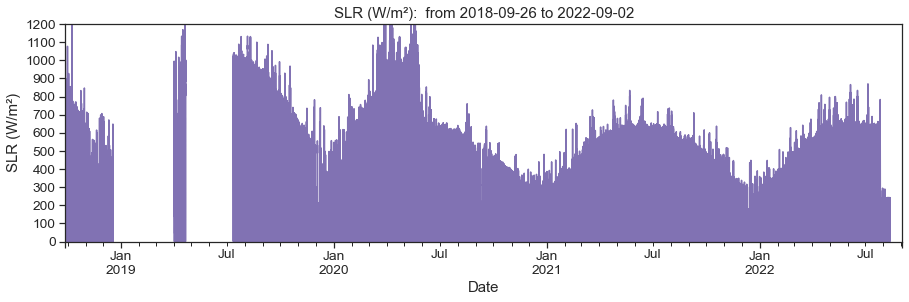

In [41]:
## EXAMPLE PLOT:
SLR(wdg_whole, ' from '+str(wdg_whole.index.date[0])+' to '+str(wdg_whole.index.date[-1]))

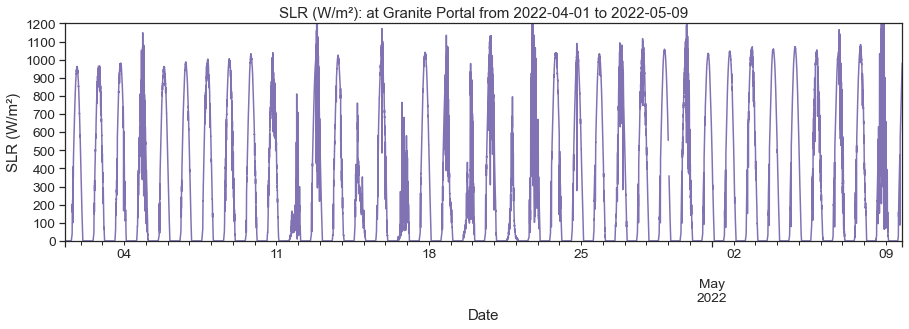

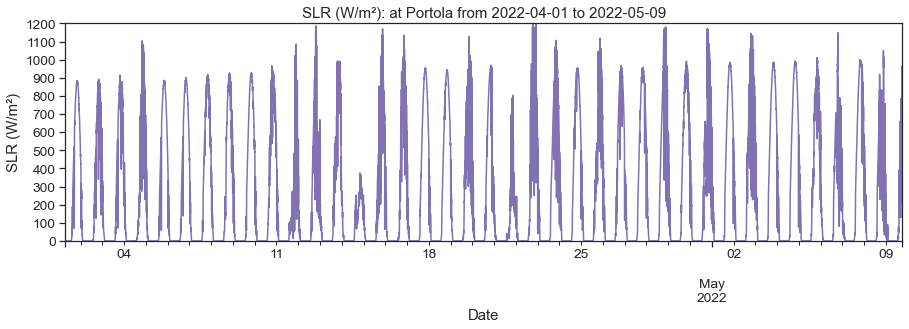

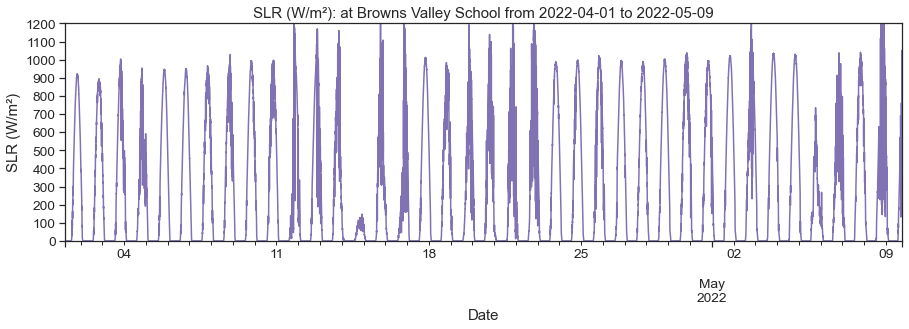

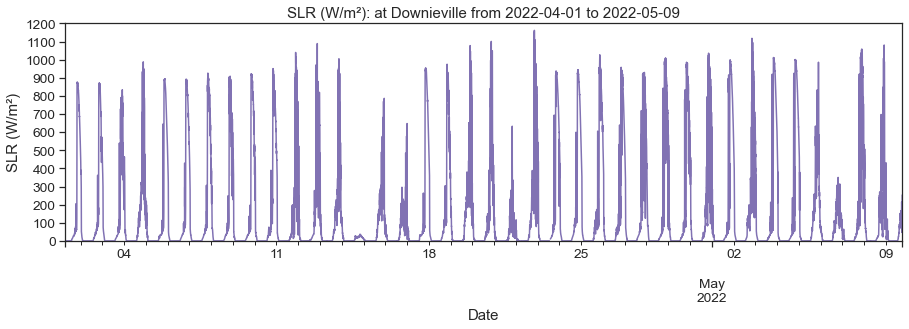

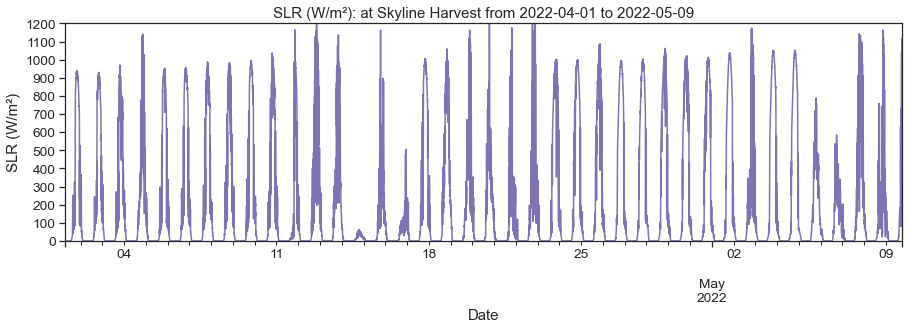

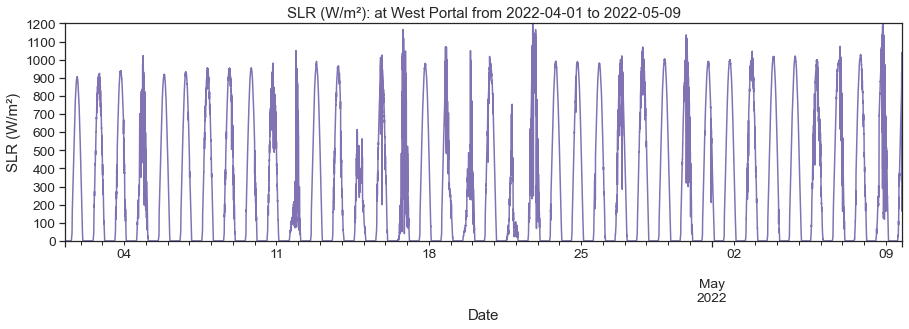

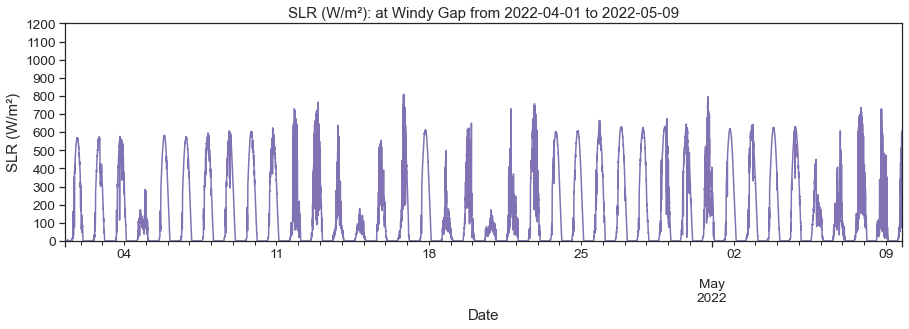

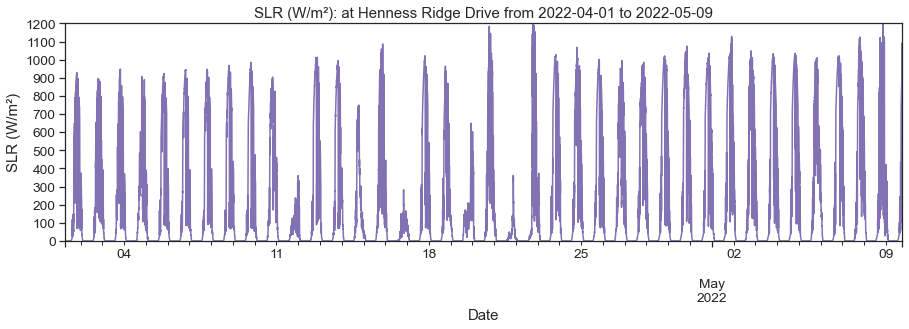

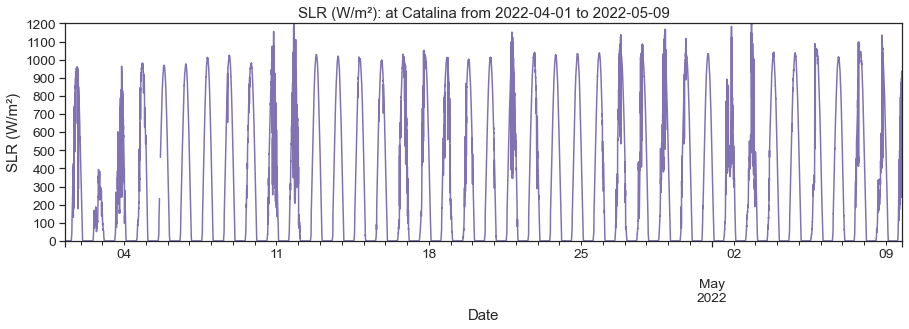

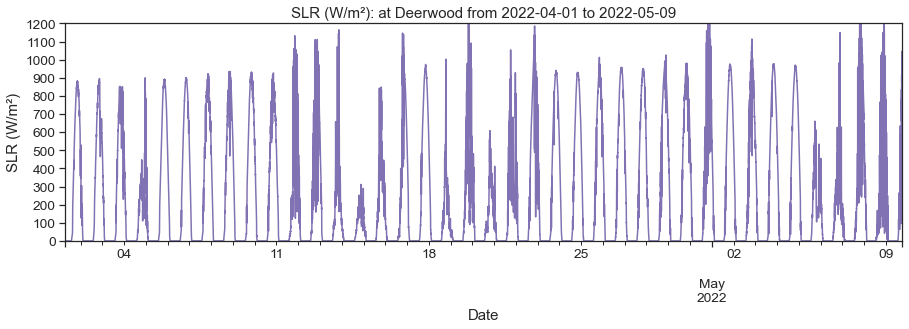

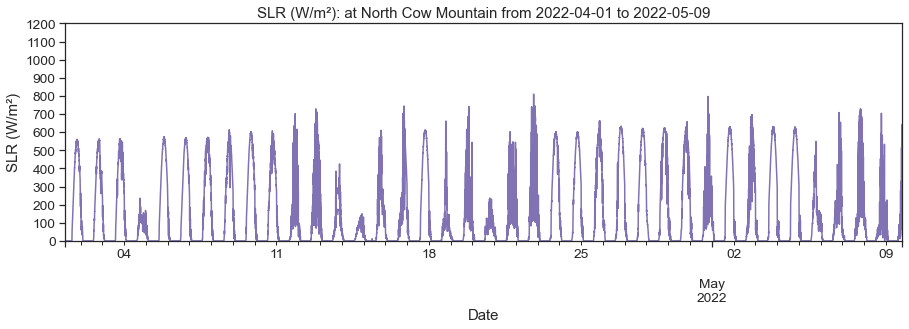

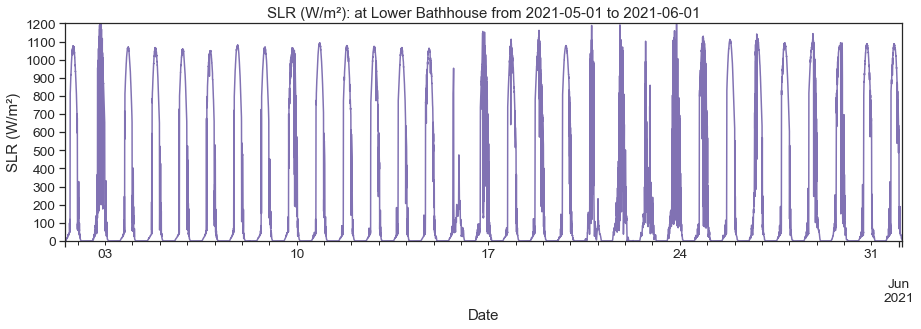

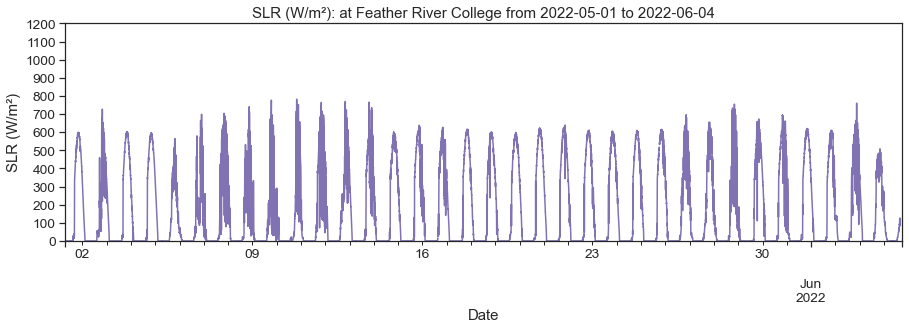

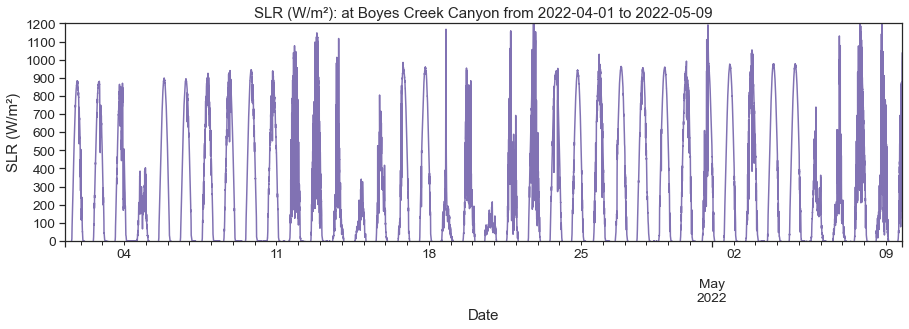

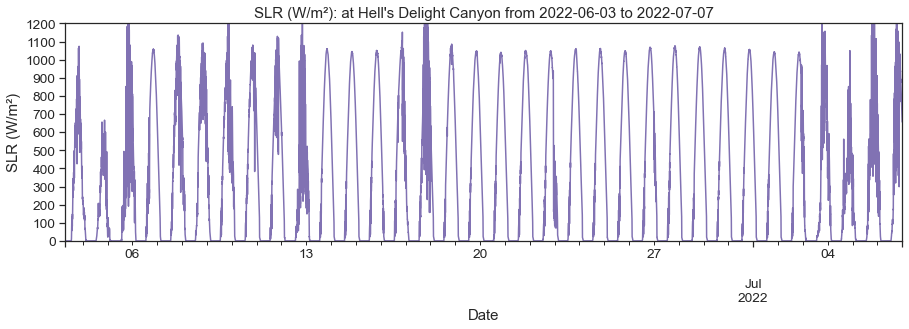

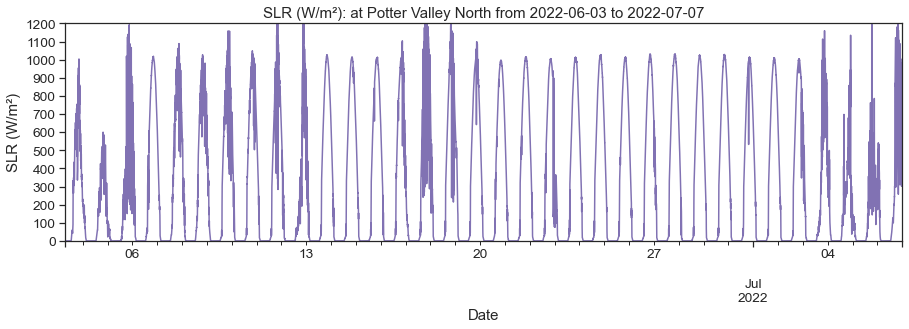

In [42]:
#most recent site to look at
for i in range(len(allsets)):
    SLR(allsets[i], 'at '+str(allsitez[i][1])+' from '+str(allsets[i].index.date[0])+' to '+str(allsets[i].index.date[-1]))
    

Henness Ridge Drive


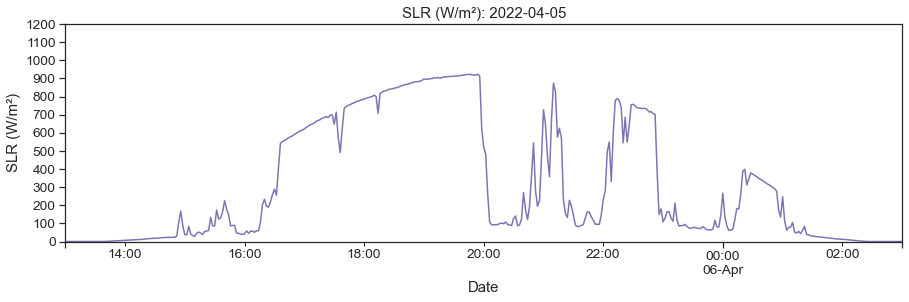

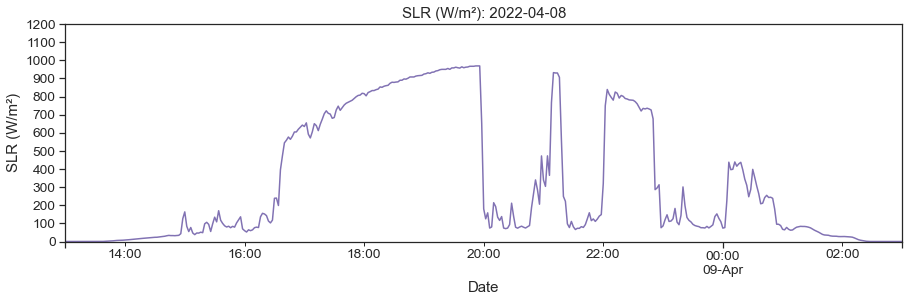

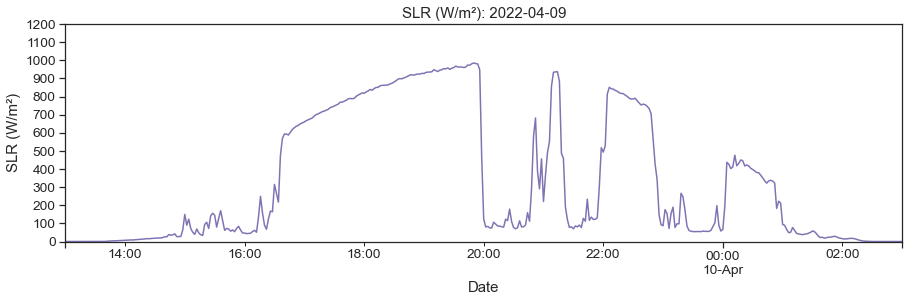

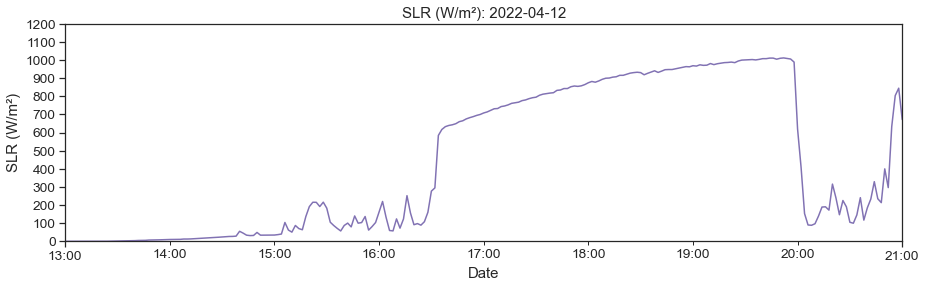

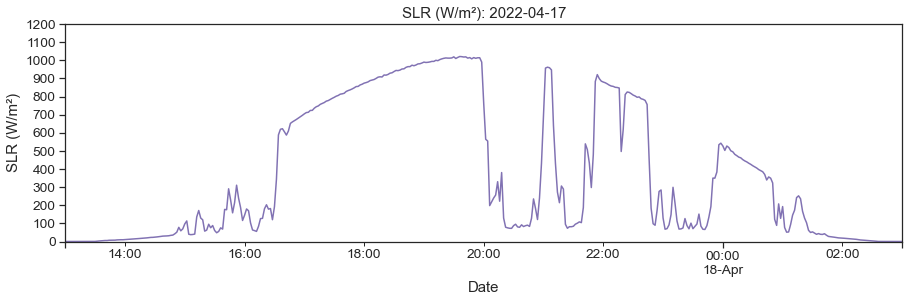

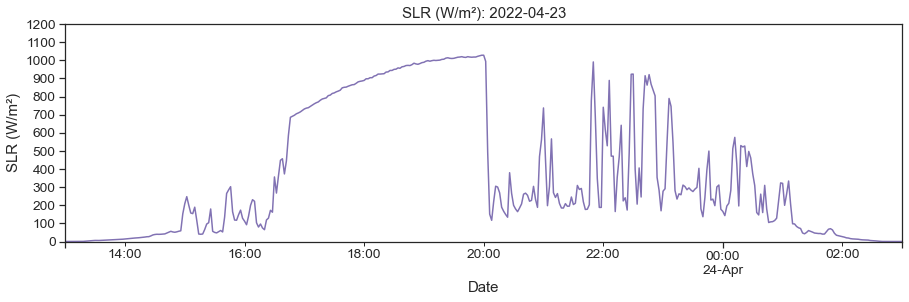

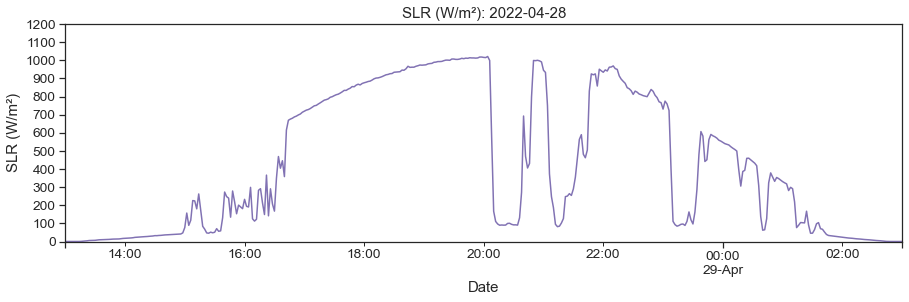

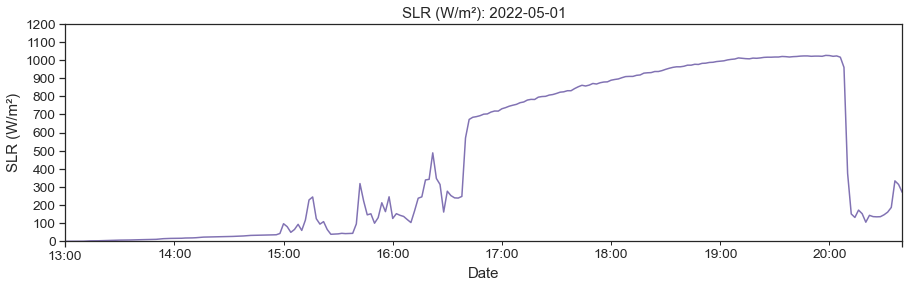

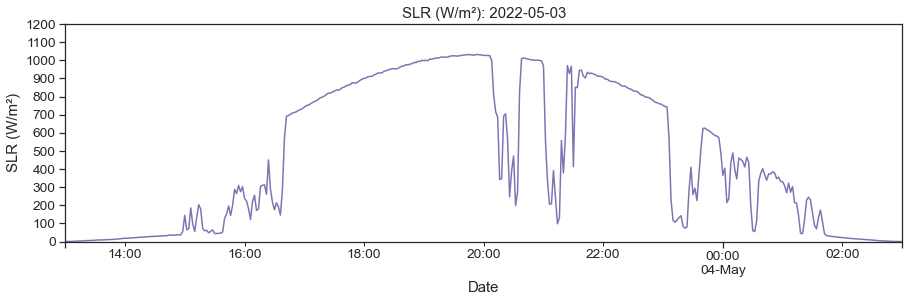

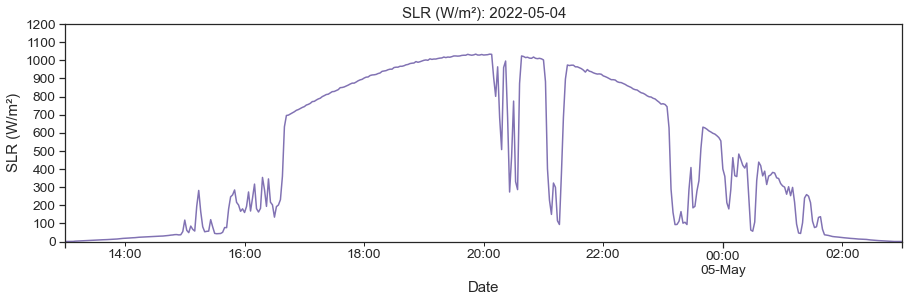

In [43]:
#To mass print all subsets/days of solar rad into separate graphs:

print(allsitez[7][1])
allSLR((allsitez[7])[2])

In [44]:
## Creating lists for specific dates, times, and quantities where solar rad is at its peak.
def dvar(locx):
    h = []
    j = []
    k = []
    for i in range(len(locx)):
        F = (locx[i])[sr].idxmax()
        h = np.append(h, F.date())
    for i in range(len(locx)):
        F = (locx[i])[sr].idxmax()
        j = np.append(j, F.time())
    for i in range(len(locx)):
        F = (locx[i])[sr].idxmax()
        k = np.append(k, locx[i][sr].max())
    return(h,j,k)

## For an easy copy/paste of said list
def printy(site):
    h, j, k = dvar(site)
    for i in range(len(site)):
        print(h[i])
    print('\n')
    for i in range(len(site)):
        print(j[i])
    print('\n')
    for i in range(len(site)):
        print(k[i])

In [45]:
printy(allsites[-1])
hi = csky(allsitez[0][2])

2022-04-01
2022-04-05
2022-04-06
2022-04-09
2022-04-17
2022-04-24
2022-04-26
2022-04-27
2022-05-01
2022-05-03
2022-05-04


20:26:00
20:20:00
20:14:00
20:14:00
20:04:00
20:14:00
20:24:00
20:02:00
20:02:00
20:02:00
20:12:00


872.0
883.0
876.0
918.0
939.0
934.0
952.0
940.0
959.0
968.0
968.0


2022-04-01 20:02:00
Temp (°C) = 18.05
RH (%) = 50.88
SLR (W/m²) = 963.0


2022-04-05 19:50:00
Temp (°C) = 18.51
RH (%) = 48.34
SLR (W/m²) = 962.0


2022-04-06 20:00:00
Temp (°C) = 22.66
RH (%) = 35.79
SLR (W/m²) = 987.0


2022-04-09 19:50:00
Temp (°C) = 22.88
RH (%) = 24.23
SLR (W/m²) = 1032.0


2022-04-17 19:54:00
Temp (°C) = 16.23
RH (%) = 51.73
SLR (W/m²) = 1041.0


2022-04-25 20:04:00
Temp (°C) = 19.62
RH (%) = 38.76
SLR (W/m²) = 1033.0


2022-04-28 19:52:00
Temp (°C) = 15.19
RH (%) = 37.63
SLR (W/m²) = 1058.0


2022-04-30 20:12:00
Temp (°C) = 19.89
RH (%) = 41.4
SLR (W/m²) = 1035.0


2022-05-01 19:52:00
Temp (°C) = 16.6
RH (%) = 43.34
SLR (W/m²) = 1048.0


2022-05-03 20:06:00
Temp (°C) = 19.66


In [46]:
# Calculating percentage error of maximum solar rad. to top 5 values in each day pe = |(m-a)/a| * 100

def percerr(name, day, var):
    maxi = np.max(day[var])
    res = day[var].nlargest(n=5)
    #print(res)
    avg = pd.DataFrame.mean(res)
    per = abs(((maxi-avg)/avg))*100
    print(name)
    print("Max: ", maxi)
    #format to three decimal places
    form_str = "{:.3f}".format(per)
    float_val = float(form_str)
    print(str(float_val)+'%')
    return per

def qerr(name, site):
    P = []
    V = np.array([], dtype = object)
    J = []
    K = []
    L = []
    M = []
    x = 0
    print('Using max. value of timeframe:')
    for i in range(len(site)):
        j = (i+1)
        J = np.append(J, j)
        v = name+' Day '+str(i+1)
        V = np.append(V, v)
        per = percerr(v, site[i], sr)
        if per <= 0.33:
            x += 1
            K = np.append(K, per)
            L = np.append(L, x)
        elif per > 0.33:
            M = np.append(M, per)
        P = np.append(P, per)    
    pT = np.mean(np.float16(P))
    print('Overall percentage error @ '+name+' is:', str(pT)+'%\n')
    return(name, V, P, pT, J, K, L, M)

def mpercerr(name, day, var, mod):
    res = day[var].nlargest(n=5)
    #print(res)
    avg = pd.DataFrame.mean(res)
    per = abs(((mod-avg)/avg))*100
    print(name)
    print("Model: ", mod)
    #format to three decimal places
    form_str = "{:.3f}".format(per)
    float_val = float(form_str)
    print(str(float_val)+'%')
    return per
        
def mqerr(name, site, model):
    Q = []
    V = np.array([], dtype = object)
    J = []
    print('Using the model from ClearSky:')
    for i in range(len(site)):
        j = (i+1)
        J = np.append(J, j)
        v = name+' Day '+str(i+1)
        V = np.append(V, v)
        per = mpercerr(v, site[i], sr, model[i])
        Q = np.append(Q, per)
    qT = np.mean(np.float16(Q))
    print('Overall percentage error @ '+name+' in relation to ClearSky model is:', str(qT)+'%\n')
    return(name, V, Q, qT, J)

def Perplt(site, x):
    if(site[2]).max() > 0.33: 
        plt.bar(site[6], site[5], color = ('blue','cornflowerblue','lightgreen','gold','orange','tomato'))
        plt.xticks(range(len(site[6])+1))
    else:
        plt.bar(site[4], site[2], color = ('blue','cornflowerblue','lightgreen','gold','orange','tomato'))
        plt.xticks(range(len(site[2])+1))
    plt.title(str(site[0])+' Solar Rad Percentage Errors', fontweight = 'bold', fontsize = '18')
    plt.ylabel('Percentage Error (%)', fontweight = 'bold', fontsize = '17')
    plt.yticks(levels)
    plt.show()
    print('Where PE = |(M-A)/A|*100, the errors are:', np.float64(site[2]))
    if(np.array(site[7]).size > 0):
        print('At '+str(site[0])+', these percentage values were anomalous to the other days:'+str(site[7]))
    else:
        return
    
def MPerplt(site, x):
    plt.bar(site[4], site[2], color = ('blue','cornflowerblue','lightgreen','gold','orange','tomato'))
    plt.title(str(site[0])+' Solar Rad Percentage Errors w/ Model', fontweight = 'bold', fontsize = '18')
    plt.xlabel(str(x), fontweight = 'bold', fontsize = '17')
    plt.xticks(range(len(site[2])+1))
    plt.ylabel('Percentage Error (%)', fontweight = 'bold', fontsize = '17')
    plt.show()
    print('Where PE = |(M-A)/A|*100, the errors are:', np.float64(site[2]))
    
def twodec(value):
    form_str = "{:.2f}".format(value)
    fl_val = float(form_str)

    return(fl_val)

Using max. value of timeframe:
GPO Day 1
Max:  963.0
0.25%
GPO Day 2
Max:  962.0
0.042%
GPO Day 3
Max:  987.0
0.122%
GPO Day 4
Max:  1032.0
0.078%
GPO Day 5
Max:  1041.0
0.192%
GPO Day 6
Max:  1033.0
0.116%
GPO Day 7
Max:  1058.0
0.208%
GPO Day 8
Max:  1035.0
0.116%
GPO Day 9
Max:  1048.0
0.076%
GPO Day 10
Max:  1059.0
0.095%
GPO Day 11
Max:  1072.0
0.149%
Overall percentage error @ GPO is: 0.1313%

Using the model from ClearSky:
GPO Day 1
Model:  881
8.286%
GPO Day 2
Model:  893
7.134%
GPO Day 3
Model:  900
8.704%
GPO Day 4
Model:  926
10.202%
GPO Day 5
Model:  940
9.528%
GPO Day 6
Model:  962
6.765%
GPO Day 7
Model:  984
6.801%
GPO Day 8
Model:  970
6.171%
GPO Day 9
Model:  980
6.417%
GPO Day 10
Model:  977
7.656%
GPO Day 11
Model:  982
8.259%
Overall percentage error @ GPO in relation to ClearSky model is: 7.812%



Where PE = |(M-A)/A|*100, the errors are: [0.25 0.04 0.12 0.08 0.19 0.12 0.21 0.12 0.08 0.09 0.15]


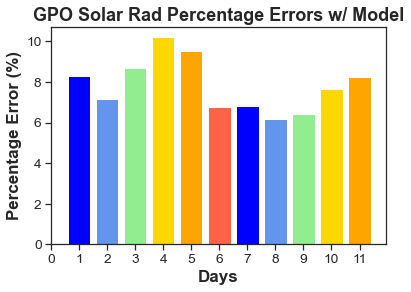

Where PE = |(M-A)/A|*100, the errors are: [8.29 7.13 8.70 10.20 9.53 6.76 6.80 6.17 6.42 7.66 8.26]


In [47]:
levels = np.arange(0, 0.35, step = 0.05)
mgpo = [881, 893, 900, 926, 940, 962, 984, 970, 980, 977, 982]

gran = qerr('GPO', gpox)
granm = mqerr('GPO', gpox, mgpo)

Perplt(gran, 'Days')
MPerplt(granm, 'Days')

Using max. value of timeframe:
POR Day 1
Max:  884.0
0.068%
POR Day 2
Max:  886.0
0.158%
POR Day 3
Max:  900.0
0.223%
POR Day 4
Max:  926.0
0.065%
POR Day 5
Max:  953.0
0.063%
POR Day 6
Max:  944.0
0.149%
POR Day 7
Max:  954.0
0.084%
POR Day 8
Max:  958.0
0.251%
POR Day 9
Max:  986.0
0.163%
POR Day 10
Max:  986.0
0.163%
POR Day 11
Max:  992.0
0.061%
Overall percentage error @ POR is: 0.1315%

Using the model from ClearSky:
POR Day 1
Model:  886
0.294%
POR Day 2
Model:  901
1.854%
POR Day 3
Model:  910
1.336%
POR Day 4
Model:  925
0.043%
POR Day 5
Model:  949
0.357%
POR Day 6
Model:  947
0.467%
POR Day 7
Model:  967
1.448%
POR Day 8
Model:  963
0.774%
POR Day 9
Model:  983
0.142%
POR Day 10
Model:  986
0.163%
POR Day 11
Model:  982
0.948%
Overall percentage error @ POR in relation to ClearSky model is: 0.7114%



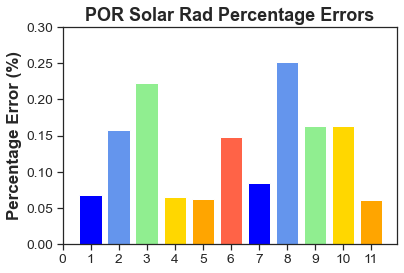

Where PE = |(M-A)/A|*100, the errors are: [0.07 0.16 0.22 0.06 0.06 0.15 0.08 0.25 0.16 0.16 0.06]


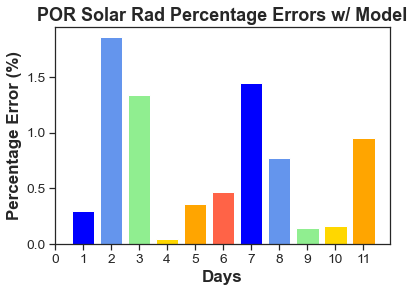

Where PE = |(M-A)/A|*100, the errors are: [0.29 1.85 1.34 0.04 0.36 0.47 1.45 0.77 0.14 0.16 0.95]


In [48]:
levels = np.arange(0, 0.35, step = 0.05)
mpor = [886, 901, 910, 925, 949, 947, 967, 963, 983, 986, 982]

port = qerr('POR', porx)
portm = mqerr('POR', porx, mpor)

Perplt(port, 'Days')
MPerplt(portm, 'Days')

Using max. value of timeframe:
BVS Day 1
Max:  921.0
0.087%
BVS Day 2
Max:  947.0
0.148%
BVS Day 3
Max:  951.0
0.063%
BVS Day 4
Max:  995.0
0.121%
BVS Day 5
Max:  1013.0
0.237%
BVS Day 6
Max:  988.0
0.101%
BVS Day 7
Max:  996.0
0.141%
BVS Day 8
Max:  1002.0
0.02%
BVS Day 9
Max:  1023.0
0.078%
BVS Day 10
Max:  1035.0
0.058%
BVS Day 11
Max:  1031.0
0.175%
Overall percentage error @ BVS is: 0.11176%

Using the model from ClearSky:
BVS Day 1
Model:  844
8.281%
BVS Day 2
Model:  878
7.149%
BVS Day 3
Model:  880
7.407%
BVS Day 4
Model:  905
8.935%
BVS Day 5
Model:  907
10.251%
BVS Day 6
Model:  926
6.18%
BVS Day 7
Model:  924
7.098%
BVS Day 8
Model:  938
6.369%
BVS Day 9
Model:  949
7.161%
BVS Day 10
Model:  955
7.676%
BVS Day 11
Model:  944
8.278%
Overall percentage error @ BVS in relation to ClearSky model is: 7.707%



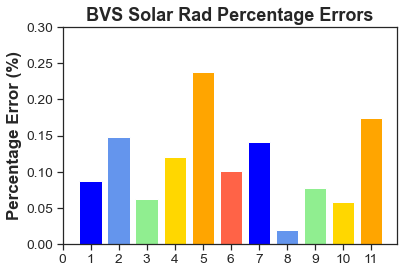

Where PE = |(M-A)/A|*100, the errors are: [0.09 0.15 0.06 0.12 0.24 0.10 0.14 0.02 0.08 0.06 0.17]


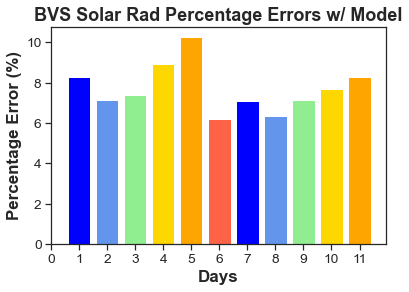

Where PE = |(M-A)/A|*100, the errors are: [8.28 7.15 7.41 8.94 10.25 6.18 7.10 6.37 7.16 7.68 8.28]


In [49]:
levels = np.arange(0, 0.35, step = 0.05)
mbvs = [844, 878, 880, 905, 907, 926, 924, 938, 949, 955, 944]

brow = qerr('BVS', bvsx)
browm = mqerr('BVS', bvsx, mbvs)

Perplt(brow, 'Days')
MPerplt(browm, 'Days')

In [50]:
levels = np.arange(0, 0.35, step = 0.05)
mdla = [872, 883, 892, 903, 925, 951, 974, 976, 967]

down = qerr('DLA', dlax)
downm = mqerr('DLA', dlax, mdla)

Perplt(down, 'Days')
MPerplt(downm, 'Days')

Using max. value of timeframe:
DLA Day 1
Max:  875.0
0.023%
DLA Day 2
Max:  895.0
0.067%
DLA Day 3
Max:  893.0
0.157%
DLA Day 4
Max:  921.0
0.043%
DLA Day 5
Max:  955.0
0.21%
DLA Day 6
Max:  945.0
0.276%
DLA Day 7
Max:  999.0
0.321%
DLA Day 8
Max:  1012.0
0.079%
DLA Day 9
Max:  1001.0
0.14%
Overall percentage error @ DLA is: 0.1462%

Using the model from ClearSky:
DLA Day 1
Model:  872
0.32%
DLA Day 2
Model:  883
1.275%
DLA Day 3
Model:  892
0.045%
DLA Day 4
Model:  903
1.912%
DLA Day 5
Model:  925
2.938%
DLA Day 6
Model:  951
0.913%
DLA Day 7
Model:  974
2.189%
DLA Day 8
Model:  976
3.481%
DLA Day 9
Model:  967
3.261%
Overall percentage error @ DLA in relation to ClearSky model is: 1.814%



Where PE = |(M-A)/A|*100, the errors are: [0.02 0.07 0.16 0.04 0.21 0.28 0.32 0.08 0.14]


Where PE = |(M-A)/A|*100, the errors are: [0.32 1.27 0.04 1.91 2.94 0.91 2.19 3.48 3.26]


Using max. value of timeframe:
SKY Day 1
Max:  940.0
0.128%
SKY Day 2
Max:  930.0
0.151%
SKY Day 3
Max:  953.0
0.634%
SKY Day 4
Max:  956.0
0.231%
SKY Day 5
Max:  1006.0
0.159%
SKY Day 6
Max:  1004.0
0.541%
SKY Day 7
Max:  997.0
0.161%
SKY Day 8
Max:  1005.0
0.56%
SKY Day 9
Max:  1037.0
0.116%
SKY Day 10
Max:  1051.0
0.076%
SKY Day 11
Max:  1052.0
0.114%
Overall percentage error @ SKY is: 0.261%

Using the model from ClearSky:
SKY Day 1
Model:  863
8.074%
SKY Day 2
Model:  871
6.203%
SKY Day 3
Model:  852
10.032%
SKY Day 4
Model:  890
6.689%
SKY Day 5
Model:  917
8.702%
SKY Day 6
Model:  929
6.97%
SKY Day 7
Model:  944
5.164%
SKY Day 8
Model:  943
5.643%
SKY Day 9
Model:  969
6.449%
SKY Day 10
Model:  962
8.398%
SKY Day 11
Model:  956
9.022%
Overall percentage error @ SKY in relation to ClearSky model is: 7.395%

[0.13 0.15 0.23 0.16 0.16 0.12 0.08 0.11]
[1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00]
0.63% 0.54% 0.56%


Where PE = |(M-A)/A|*100, the errors are: [0.13 0.15 0.63 0.23 0.16 0.54 0.16 0.56 0.12 0.08 0.11]
At SKY, these percentage values were anomalous to the other days:[0.63 0.54 0.56]


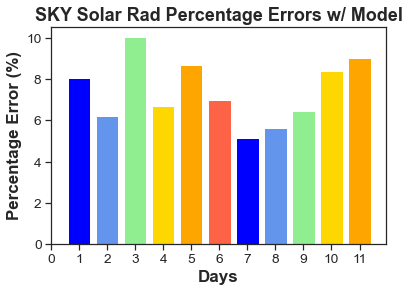

Where PE = |(M-A)/A|*100, the errors are: [8.07 6.20 10.03 6.69 8.70 6.97 5.16 5.64 6.45 8.40 9.02]


In [51]:
levels = np.arange(0, 0.35, step = 0.05)
msky = [863, 871, 852, 890, 917, 929, 944, 943, 969, 962, 956]

skyl = qerr('SKY', skyx)
skylm = mqerr('SKY', skyx, msky)
print(skyl[5])
print(skyl[6])
## NOTE: 3, 5, & 7 high error
print(str(twodec(skyl[7][0]))+'%', str(twodec(skyl[7][1]))+'%', str(twodec(skyl[7][2]))+'%')

Perplt(skyl, 'Days')
MPerplt(skylm, 'Days')

Using max. value of timeframe:
WPO Day 1
Max:  904.0
0.044%
WPO Day 2
Max:  919.0
0.087%
WPO Day 3
Max:  932.0
0.043%
WPO Day 4
Max:  955.0
0.063%
WPO Day 5
Max:  991.0
0.63%
WPO Day 6
Max:  980.0
0.266%
WPO Day 7
Max:  991.0
0.101%
WPO Day 8
Max:  1005.0
0.299%
WPO Day 9
Max:  1000.0
0.18%
WPO Day 10
Max:  1018.0
0.118%
WPO Day 11
Max:  1019.0
0.098%
Overall percentage error @ WPO is: 0.1754%

Using the model from ClearSky:
WPO Day 1
Model:  864
4.382%
WPO Day 2
Model:  880
4.16%
WPO Day 3
Model:  886
4.895%
WPO Day 4
Model:  906
5.071%
WPO Day 5
Model:  937
4.854%
WPO Day 6
Model:  918
6.077%
WPO Day 7
Model:  949
4.141%
WPO Day 8
Model:  966
3.593%
WPO Day 9
Model:  949
4.929%
WPO Day 10
Model:  979
3.718%
WPO Day 11
Model:  970
4.715%
Overall percentage error @ WPO in relation to ClearSky model is: 4.594%



Where PE = |(M-A)/A|*100, the errors are: [0.04 0.09 0.04 0.06 0.63 0.27 0.10 0.30 0.18 0.12 0.10]
At WPO, these percentage values were anomalous to the other days:[0.63]


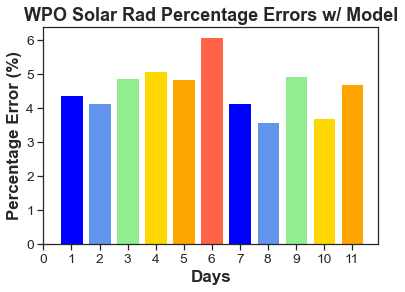

Where PE = |(M-A)/A|*100, the errors are: [4.38 4.16 4.89 5.07 4.85 6.08 4.14 3.59 4.93 3.72 4.72]


In [52]:
mwest = [864, 880, 886, 906, 937, 918, 949, 966, 949, 979, 970]

west = qerr('WPO', wpox)
westm = mqerr('WPO', wpox, mwest)

Perplt(west, 'Days')
MPerplt(westm, 'Days')
 
#print(west[5])
#westb = (west[2])[np.arange(len(west[2]))!=3]  # b = array([9, 8, 7, 5, 4, 3, 2, 1, 0])
#print(westb)

In [53]:
mwdy = [892, 883, 911, 916, 939, 942, 935, 945, 957, 976, 959]

wind = qerr('WDG', wdgx)
windm = mqerr('WDG', wdgx, mwdy)

Perplt(wind, 'Days')
MPerplt(windm, 'Days')

print("{:.3f}".format((wind[2])[3])+'%')

Using max. value of timeframe:
WDG Day 1
Max:  582.5
0.048%
WDG Day 2
Max:  575.0
0.185%
WDG Day 3
Max:  604.8
0.166%
WDG Day 4
Max:  612.2
0.318%
WDG Day 5
Max:  602.5
0.13%
WDG Day 6
Max:  608.7
0.095%
WDG Day 7
Max:  629.5
0.143%
WDG Day 8
Max:  625.8
0.096%
WDG Day 9
Max:  619.7
0.09%
WDG Day 10
Max:  626.1
0.083%
WDG Day 11
Max:  629.7
0.095%
Overall percentage error @ WDG is: 0.1317%

Using the model from ClearSky:
WDG Day 1
Model:  892
53.207%
WDG Day 2
Model:  883
53.849%
WDG Day 3
Model:  911
50.878%
WDG Day 4
Model:  916
50.1%
WDG Day 5
Model:  939
56.053%
WDG Day 6
Model:  942
54.904%
WDG Day 7
Model:  935
48.743%
WDG Day 8
Model:  945
51.152%
WDG Day 9
Model:  957
54.569%
WDG Day 10
Model:  976
56.015%
WDG Day 11
Model:  959
52.44%
Overall percentage error @ WDG in relation to ClearSky model is: 52.9%



Where PE = |(M-A)/A|*100, the errors are: [0.05 0.18 0.17 0.32 0.13 0.10 0.14 0.10 0.09 0.08 0.10]


Where PE = |(M-A)/A|*100, the errors are: [53.21 53.85 50.88 50.10 56.05 54.90 48.74 51.15 54.57 56.02 52.44]
0.318%


Using max. value of timeframe:
HRD Day 1
Max:  923.0
0.152%
HRD Day 2
Max:  945.0
0.127%
HRD Day 3
Max:  969.0
0.083%
HRD Day 4
Max:  985.0
0.469%
HRD Day 5
Max:  1012.0
0.139%
HRD Day 6
Max:  1021.0
0.157%
HRD Day 7
Max:  1028.0
0.332%
HRD Day 8
Max:  1021.0
0.334%
HRD Day 9
Max:  1026.0
0.195%
HRD Day 10
Max:  1032.0
0.078%
HRD Day 11
Max:  1034.0
0.077%
Overall percentage error @ HRD is: 0.1948%

Using the model from ClearSky:
HRD Day 1
Model:  913
0.933%
HRD Day 2
Model:  927
1.78%
HRD Day 3
Model:  941
2.809%
HRD Day 4
Model:  945
3.611%
HRD Day 5
Model:  979
3.127%
HRD Day 6
Model:  972
4.65%
HRD Day 7
Model:  982
4.158%
HRD Day 8
Model:  1006
1.14%
HRD Day 9
Model:  994
2.93%
HRD Day 10
Model:  1000
3.026%
HRD Day 11
Model:  1001
3.117%
Overall percentage error @ HRD in relation to ClearSky model is: 2.844%



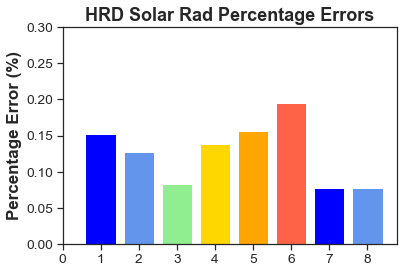

Where PE = |(M-A)/A|*100, the errors are: [0.15 0.13 0.08 0.47 0.14 0.16 0.33 0.33 0.20 0.08 0.08]
At HRD, these percentage values were anomalous to the other days:[0.47 0.33 0.33]


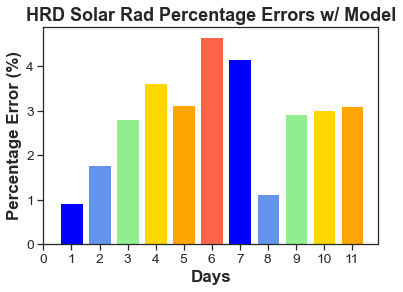

Where PE = |(M-A)/A|*100, the errors are: [0.93 1.78 2.81 3.61 3.13 4.65 4.16 1.14 2.93 3.03 3.12]


In [54]:
mhen = [913, 927, 941, 945, 979, 972, 982, 1006, 994, 1000, 1001]

henn = qerr('HRD', hrdx)
hennm = mqerr('HRD', hrdx, mhen)

Perplt(henn, 'Days')
MPerplt(hennm, 'Days')

Using max. value of timeframe:
CAT Day 1
Max:  977.0
0.144%
CAT Day 2
Max:  1013.0
0.138%
CAT Day 3
Max:  1024.0
0.059%
CAT Day 4
Max:  1029.0
0.078%
CAT Day 5
Max:  1019.0
0.098%
CAT Day 6
Max:  1027.0
0.078%
CAT Day 7
Max:  1034.0
0.116%
CAT Day 8
Max:  1037.0
0.077%
CAT Day 9
Max:  1033.0
0.097%
CAT Day 10
Max:  1036.0
0.077%
CAT Day 11
Max:  1015.0
0.158%
Overall percentage error @ CAT is: 0.1018%

Using the model from ClearSky:
CAT Day 1
Model:  893
8.467%
CAT Day 2
Model:  937
7.374%
CAT Day 3
Model:  944
7.758%
CAT Day 4
Model:  957
6.925%
CAT Day 5
Model:  953
6.385%
CAT Day 6
Model:  955
6.938%
CAT Day 7
Model:  978
5.306%
CAT Day 8
Model:  970
6.389%
CAT Day 9
Model:  957
7.267%
CAT Day 10
Model:  962
7.071%
CAT Day 11
Model:  962
5.072%
Overall percentage error @ CAT in relation to ClearSky model is: 6.812%



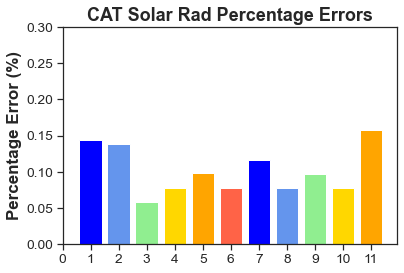

Where PE = |(M-A)/A|*100, the errors are: [0.14 0.14 0.06 0.08 0.10 0.08 0.12 0.08 0.10 0.08 0.16]


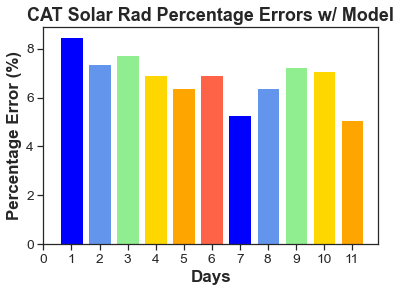

Where PE = |(M-A)/A|*100, the errors are: [8.47 7.37 7.76 6.92 6.39 6.94 5.31 6.39 7.27 7.07 5.07]


In [55]:
mcat = [893, 937, 944, 957, 953, 955, 978, 970, 957, 962, 962]

cata = qerr('CAT', catx)
catam = mqerr('CAT', catx, mcat)

Perplt(cata, 'Days')
MPerplt(catam, 'Days')

Using max. value of timeframe:
DRW Day 1
Max:  882.0
0.136%
DRW Day 2
Max:  892.0
0.135%
DRW Day 3
Max:  900.0
0.067%
DRW Day 4
Max:  932.0
0.129%
DRW Day 5
Max:  974.0
0.206%
DRW Day 6
Max:  930.0
0.151%
DRW Day 7
Max:  957.0
0.0%
DRW Day 8
Max:  951.0
0.042%
DRW Day 9
Max:  976.0
0.041%
DRW Day 10
Max:  978.0
0.164%
DRW Day 11
Max:  970.0
0.31%
Overall percentage error @ DRW is: 0.1255%

Using the model from ClearSky:
DRW Day 1
Model:  855
2.929%
DRW Day 2
Model:  872
2.11%
DRW Day 3
Model:  879
2.268%
DRW Day 4
Model:  894
3.954%
DRW Day 5
Model:  939
3.395%
DRW Day 6
Model:  933
0.474%
DRW Day 7
Model:  933
2.508%
DRW Day 8
Model:  937
1.431%
DRW Day 9
Model:  962
1.394%
DRW Day 10
Model:  962
1.475%
DRW Day 11
Model:  943
2.482%
Overall percentage error @ DRW in relation to ClearSky model is: 2.22%



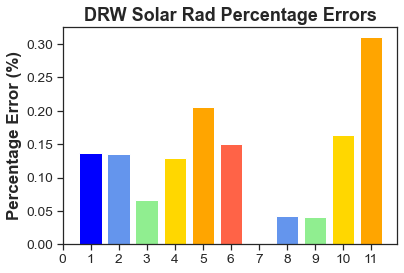

Where PE = |(M-A)/A|*100, the errors are: [0.14 0.13 0.07 0.13 0.21 0.15 0.00 0.04 0.04 0.16 0.31]


Where PE = |(M-A)/A|*100, the errors are: [2.93 2.11 2.27 3.95 3.40 0.47 2.51 1.43 1.39 1.47 2.48]


In [56]:
mdrw = 855, 872, 879, 894, 939, 933, 933, 937, 962, 962, 943

deer = qerr('DRW', drwx)
deerm = mqerr('DRW', drwx, mdrw)

Perplt(deer, 'Days')
MPerplt(deerm, 'Days')

Using max. value of timeframe:
NCM Day 1
Max:  559.8
0.05%
NCM Day 2
Max:  574.6
0.37%
NCM Day 3
Max:  569.4
0.172%
NCM Day 4
Max:  602.8
0.189%
NCM Day 5
Max:  611.3
0.197%
NCM Day 6
Max:  603.2
0.279%
NCM Day 7
Max:  602.3
0.226%
NCM Day 8
Max:  621.1
0.184%
NCM Day 9
Max:  631.0
0.324%
NCM Day 10
Max:  631.3
0.2%
NCM Day 11
Max:  628.5
0.217%
Overall percentage error @ NCM is: 0.219%

Using the model from ClearSky:
NCM Day 1
Model:  864
54.418%
NCM Day 2
Model:  896
56.512%
NCM Day 3
Model:  893
57.102%
NCM Day 4
Model:  912
51.581%
NCM Day 5
Model:  921
50.959%
NCM Day 6
Model:  952
58.266%
NCM Day 7
Model:  949
57.919%
NCM Day 8
Model:  955
54.042%
NCM Day 9
Model:  963
53.11%
NCM Day 10
Model:  976
54.911%
NCM Day 11
Model:  963
53.554%
Overall percentage error @ NCM in relation to ClearSky model is: 54.75%



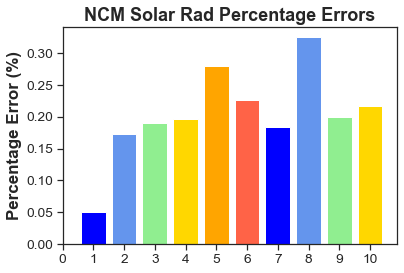

Where PE = |(M-A)/A|*100, the errors are: [0.05 0.37 0.17 0.19 0.20 0.28 0.23 0.18 0.32 0.20 0.22]
At NCM, these percentage values were anomalous to the other days:[0.37]


Where PE = |(M-A)/A|*100, the errors are: [54.42 56.51 57.10 51.58 50.96 58.27 57.92 54.04 53.11 54.91 53.55]


In [57]:
mncm = 864, 896, 893, 912, 921, 952, 949, 955, 963, 976, 963

cow = qerr('NCM', ncmx)
cowm = mqerr('NCM', ncmx, mncm)

Perplt(cow, 'Days')
MPerplt(cowm, 'Days')

Using max. value of timeframe:
LBH Day 1
Max:  1077.0
0.205%
LBH Day 2
Max:  1070.0
0.112%
LBH Day 3
Max:  1067.0
0.15%
LBH Day 4
Max:  1059.0
0.038%
LBH Day 5
Max:  1081.0
0.093%
LBH Day 6
Max:  1069.0
0.056%
LBH Day 7
Max:  1093.0
0.183%
LBH Day 8
Max:  1078.0
0.13%
LBH Day 9
Max:  1074.0
0.168%
LBH Day 10
Max:  1067.0
0.15%
LBH Day 11
Max:  1088.0
0.166%
Overall percentage error @ LBH is: 0.1318%

Using the model from ClearSky:
LBH Day 1
Model:  993
7.611%
LBH Day 2
Model:  995
6.905%
LBH Day 3
Model:  984
7.64%
LBH Day 4
Model:  977
7.708%
LBH Day 5
Model:  993
8.056%
LBH Day 6
Model:  1014
5.092%
LBH Day 7
Model:  1011
7.333%
LBH Day 8
Model:  1004
6.743%
LBH Day 9
Model:  1006
6.174%
LBH Day 10
Model:  998
6.326%
LBH Day 11
Model:  1017
6.371%
Overall percentage error @ LBH in relation to ClearSky model is: 6.906%



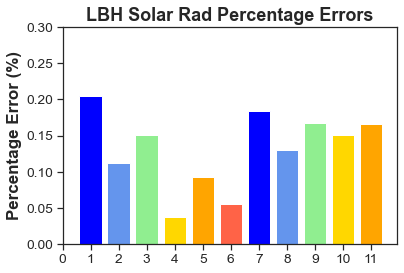

Where PE = |(M-A)/A|*100, the errors are: [0.20 0.11 0.15 0.04 0.09 0.06 0.18 0.13 0.17 0.15 0.17]


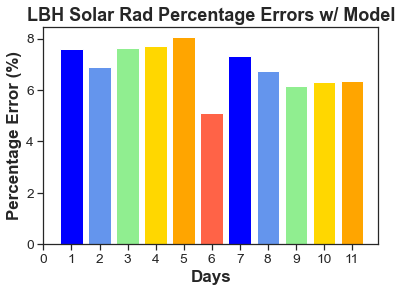

Where PE = |(M-A)/A|*100, the errors are: [7.61 6.90 7.64 7.71 8.06 5.09 7.33 6.74 6.17 6.33 6.37]


In [58]:
mlbh = 993, 995, 984, 977, 993, 1014, 1011, 1004, 1006, 998, 1017

bath = qerr('LBH', lbhx)
bathm = mqerr('LBH', lbhx, mlbh)

Perplt(bath, 'Days')
MPerplt(bathm, 'Days')

Using max. value of timeframe:
FRC Day 1
Max:  598.9
0.084%
FRC Day 2
Max:  604.1
0.65%
FRC Day 3
Max:  596.0
0.121%
FRC Day 4
Max:  616.7
0.319%
FRC Day 5
Max:  599.1
0.628%
FRC Day 6
Max:  623.1
0.552%
FRC Day 7
Max:  611.8
0.489%
FRC Day 8
Max:  606.1
0.437%
FRC Day 9
Max:  610.3
0.325%
FRC Day 10
Max:  615.2
0.323%
FRC Day 11
Max:  619.9
0.158%
Overall percentage error @ FRC is: 0.3716%

Using the model from ClearSky:
FRC Day 1
Model:  969
61.932%
FRC Day 2
Model:  967
61.113%
FRC Day 3
Model:  969
62.781%
FRC Day 4
Model:  986
60.393%
FRC Day 5
Model:  978
64.27%
FRC Day 6
Model:  1018
64.278%
FRC Day 7
Model:  993
63.102%
FRC Day 8
Model:  987
63.557%
FRC Day 9
Model:  996
63.73%
FRC Day 10
Model:  973
58.671%
FRC Day 11
Model:  1008
62.864%
Overall percentage error @ FRC in relation to ClearSky model is: 62.44%



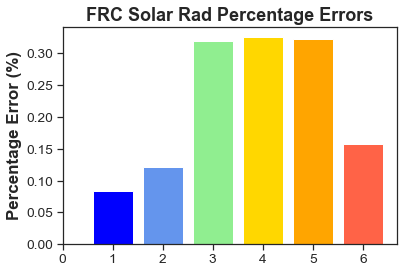

Where PE = |(M-A)/A|*100, the errors are: [0.08 0.65 0.12 0.32 0.63 0.55 0.49 0.44 0.33 0.32 0.16]
At FRC, these percentage values were anomalous to the other days:[0.65 0.63 0.55 0.49 0.44]


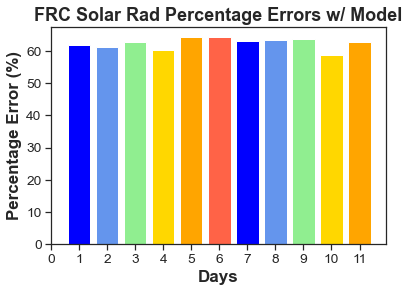

Where PE = |(M-A)/A|*100, the errors are: [61.93 61.11 62.78 60.39 64.27 64.28 63.10 63.56 63.73 58.67 62.86]


In [59]:
mfrc = 969, 967, 969, 986, 978, 1018, 993, 987, 996, 973, 1008

feat = qerr('FRC', frcx)
featm = mqerr('FRC', frcx, mfrc)

Perplt(feat, 'Days')
MPerplt(featm, 'Days')

Using max. value of timeframe:
BCC Day 1
Max:  883.0
0.182%
BCC Day 2
Max:  898.0
0.067%
BCC Day 3
Max:  893.0
0.067%
BCC Day 4
Max:  959.0
0.042%
BCC Day 5
Max:  942.0
0.064%
BCC Day 6
Max:  963.0
0.208%
BCC Day 7
Max:  954.0
0.084%
BCC Day 8
Max:  959.0
0.083%
BCC Day 9
Max:  976.0
0.164%
BCC Day 10
Max:  978.0
0.061%
BCC Day 11
Max:  978.0
0.287%
Overall percentage error @ BCC is: 0.119%

Using the model from ClearSky:
BCC Day 1
Model:  849
3.676%
BCC Day 2
Model:  880
1.939%
BCC Day 3
Model:  860
3.631%
BCC Day 4
Model:  930
2.984%
BCC Day 5
Model:  941
0.042%
BCC Day 6
Model:  937
2.497%
BCC Day 7
Model:  942
1.175%
BCC Day 8
Model:  949
0.96%
BCC Day 9
Model:  936
3.941%
BCC Day 10
Model:  945
3.315%
BCC Day 11
Model:  940
3.61%
Overall percentage error @ BCC in relation to ClearSky model is: 2.525%



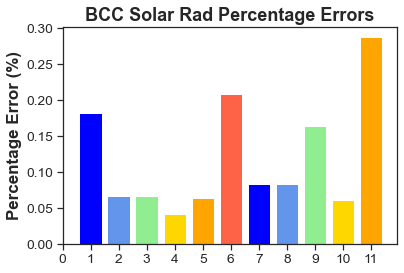

Where PE = |(M-A)/A|*100, the errors are: [0.18 0.07 0.07 0.04 0.06 0.21 0.08 0.08 0.16 0.06 0.29]


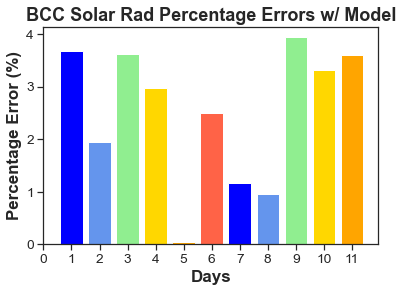

Where PE = |(M-A)/A|*100, the errors are: [3.68 1.94 3.63 2.98 0.04 2.50 1.17 0.96 3.94 3.31 3.61]


In [60]:
mbcc = 849, 880, 860, 930, 941, 937, 942, 949, 936, 945, 940

boy = qerr('BCC', bccx)
boym = mqerr('BCC', bccx, mbcc)

Perplt(boy, 'Days')
MPerplt(boym, 'Days')

Using max. value of timeframe:
NBB Day 1
Max:  885.0
0.249%
NBB Day 2
Max:  882.0
0.023%
NBB Day 3
Max:  902.0
0.089%
NBB Day 4
Max:  935.0
0.451%
NBB Day 5
Max:  951.0
0.211%
NBB Day 6
Max:  935.0
0.064%
NBB Day 7
Max:  948.0
0.211%
NBB Day 8
Max:  943.0
0.064%
NBB Day 9
Max:  987.0
0.061%
NBB Day 10
Max:  1001.0
0.12%
NBB Day 11
Max:  994.0
0.161%
Overall percentage error @ NBB is: 0.1549%

Using the model from ClearSky:
NBB Day 1
Model:  858
2.809%
NBB Day 2
Model:  866
1.792%
NBB Day 3
Model:  886
1.687%
NBB Day 4
Model:  900
3.309%
NBB Day 5
Model:  913
3.793%
NBB Day 6
Model:  932
0.257%
NBB Day 7
Model:  946
0.0%
NBB Day 8
Model:  946
0.382%
NBB Day 9
Model:  977
0.953%
NBB Day 10
Model:  962
3.781%
NBB Day 11
Model:  957
3.567%
Overall percentage error @ NBB in relation to ClearSky model is: 2.03%



Where PE = |(M-A)/A|*100, the errors are: [0.25 0.02 0.09 0.45 0.21 0.06 0.21 0.06 0.06 0.12 0.16]
At NBB, these percentage values were anomalous to the other days:[0.45]


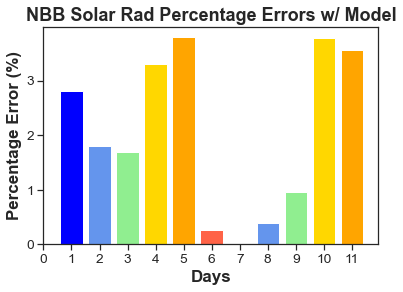

Where PE = |(M-A)/A|*100, the errors are: [2.81 1.79 1.69 3.31 3.79 0.26 0.00 0.38 0.95 3.78 3.57]


In [61]:
mnbb = 858, 866, 886, 900, 913, 932, 946, 946, 977, 962, 957

bar = qerr('NBB', nbbx)
barm = mqerr('NBB', nbbx, mnbb)

Perplt(bar, 'Days')
MPerplt(barm, 'Days')

Using max. value of timeframe:
SOD Day 1
Max:  587.5
0.414%
SOD Day 2
Max:  597.3
0.148%
SOD Day 3
Max:  612.9
0.429%
SOD Day 4
Max:  649.7
0.244%
SOD Day 5
Max:  632.0
0.589%
SOD Day 6
Max:  628.8
0.137%
SOD Day 7
Max:  621.8
0.197%
SOD Day 8
Max:  649.0
0.179%
SOD Day 9
Max:  645.5
0.233%
SOD Day 10
Max:  638.9
0.415%
SOD Day 11
Max:  653.4
0.08%
Overall percentage error @ SOD is: 0.2786%

Using the model from ClearSky:
SOD Day 1
Model:  914
56.218%
SOD Day 2
Model:  929
55.763%
SOD Day 3
Model:  961
57.469%
SOD Day 4
Model:  989
52.595%
SOD Day 5
Model:  988
57.25%
SOD Day 6
Model:  982
56.384%
SOD Day 7
Model:  970
56.305%
SOD Day 8
Model:  990
52.816%
SOD Day 9
Model:  992
54.037%
SOD Day 10
Model:  980
54.025%
SOD Day 11
Model:  1006
54.087%
Overall percentage error @ SOD in relation to ClearSky model is: 55.2%



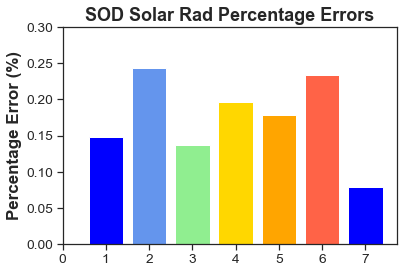

Where PE = |(M-A)/A|*100, the errors are: [0.41 0.15 0.43 0.24 0.59 0.14 0.20 0.18 0.23 0.41 0.08]
At SOD, these percentage values were anomalous to the other days:[0.41 0.43 0.59 0.41]


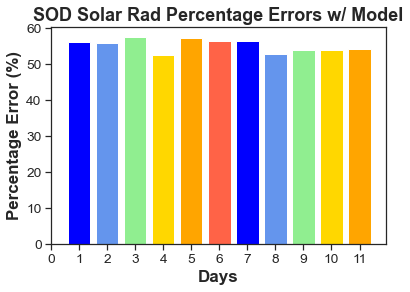

Where PE = |(M-A)/A|*100, the errors are: [56.22 55.76 57.47 52.60 57.25 56.38 56.31 52.82 54.04 54.03 54.09]


In [62]:
msod = 914, 929, 961, 989, 988, 982, 970, 990, 992, 980, 1006

sev = qerr('SOD', sodx)
sevm = mqerr('SOD', sodx, msod)

Perplt(sev, 'Days')
MPerplt(sevm, 'Days')

Using max. value of timeframe:
HDC Day 1
Max:  1059.0
0.227%
HDC Day 2
Max:  1060.0
0.057%
HDC Day 3
Max:  1045.0
0.115%
HDC Day 4
Max:  1041.0
0.173%
HDC Day 5
Max:  1051.0
0.152%
HDC Day 6
Max:  1049.0
0.019%
HDC Day 7
Max:  1068.0
0.056%
HDC Day 8
Max:  1070.0
0.112%
HDC Day 9
Max:  1065.0
0.15%
HDC Day 10
Max:  1057.0
0.152%
HDC Day 11
Max:  1044.0
0.134%
Overall percentage error @ HDC is: 0.12256%

Using the model from ClearSky:
HDC Day 1
Model:  979
7.344%
HDC Day 2
Model:  999
5.701%
HDC Day 3
Model:  994
4.771%
HDC Day 4
Model:  992
4.542%
HDC Day 5
Model:  1000
4.707%
HDC Day 6
Model:  983
6.274%
HDC Day 7
Model:  1005
5.846%
HDC Day 8
Model:  983
8.028%
HDC Day 9
Model:  987
7.185%
HDC Day 10
Model:  975
7.618%
HDC Day 11
Model:  974
6.58%
Overall percentage error @ HDC in relation to ClearSky model is: 6.234%



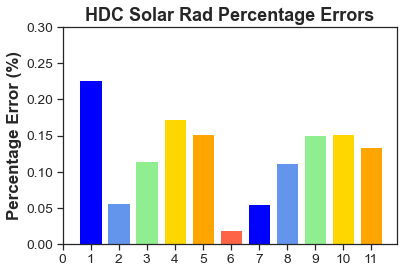

Where PE = |(M-A)/A|*100, the errors are: [0.23 0.06 0.11 0.17 0.15 0.02 0.06 0.11 0.15 0.15 0.13]


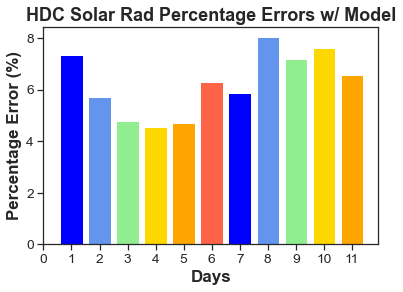

Where PE = |(M-A)/A|*100, the errors are: [7.34 5.70 4.77 4.54 4.71 6.27 5.85 8.03 7.18 7.62 6.58]


In [63]:
mhdc = 979, 999, 994, 992, 1000, 983, 1005, 983, 987, 975, 974

hell = qerr('HDC', hdcx)
hellm = mqerr('HDC', hdcx, mhdc)

Perplt(hell, 'Days')
MPerplt(hellm, 'Days')

Using max. value of timeframe:
PVN Day 1
Max:  872.0
0.23%
PVN Day 2
Max:  883.0
0.204%
PVN Day 3
Max:  876.0
0.069%
PVN Day 4
Max:  918.0
0.175%
PVN Day 5
Max:  939.0
0.128%
PVN Day 6
Max:  934.0
0.086%
PVN Day 7
Max:  952.0
0.253%
PVN Day 8
Max:  940.0
0.064%
PVN Day 9
Max:  959.0
0.083%
PVN Day 10
Max:  968.0
0.103%
PVN Day 11
Max:  968.0
0.041%
Overall percentage error @ PVN is: 0.1305%

Using the model from ClearSky:
PVN Day 1
Model:  843
3.103%
PVN Day 2
Model:  875
0.704%
PVN Day 3
Model:  866
1.074%
PVN Day 4
Model:  901
1.68%
PVN Day 5
Model:  920
1.898%
PVN Day 6
Model:  931
0.236%
PVN Day 7
Model:  924
2.696%
PVN Day 8
Model:  932
0.788%
PVN Day 9
Model:  935
2.421%
PVN Day 10
Model:  943
2.482%
PVN Day 11
Model:  949
1.922%
Overall percentage error @ PVN in relation to ClearSky model is: 1.728%



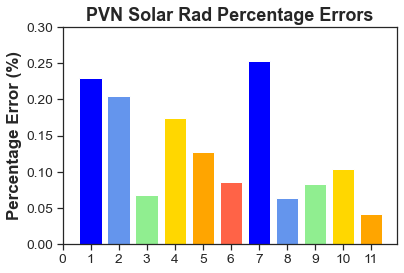

Where PE = |(M-A)/A|*100, the errors are: [0.23 0.20 0.07 0.17 0.13 0.09 0.25 0.06 0.08 0.10 0.04]


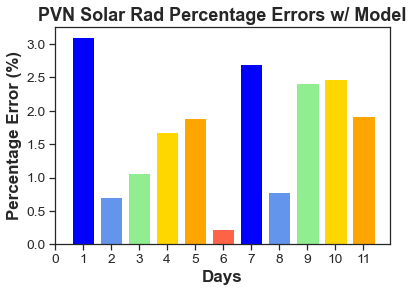

Where PE = |(M-A)/A|*100, the errors are: [3.10 0.70 1.07 1.68 1.90 0.24 2.70 0.79 2.42 2.48 1.92]


In [64]:
mpvn = 843, 875, 866, 901, 920, 931, 924, 932, 935, 943, 949

pot = qerr('PVN', pvnx)
potm = mqerr('PVN', pvnx, mpvn)

Perplt(pot, 'Days')
MPerplt(potm, 'Days')

In [65]:
allmeans = [gran, port, brow, down, skyl, west, wind, henn, cata, deer, cow, bath, feat, boy, bar, sev, hell, pot]
mallmeans= [granm, portm, browm, downm, skylm, westm, windm, hennm, catam, deerm, cowm, bathm, featm, \
            boym, barm, sevm, hellm, potm]

In [66]:
def allsite(site):
    g = []
    h = []
    j = []
    k = []
    for i in range(len(site)):
        if(site[i][3] < 50):
            g = np.append(g, site[i][0])
            h = np.append(h, site[i][3])
        else:
            j = np.append(j, site[i][0])
            k = np.append(k, site[i][3])
    return(g, h, j, k)   

def plotALL(site, z):
    x, y, a, b = allsite(site)
    plt.bar(x, y, color = ('blue','cornflowerblue','lightgreen','gold','orange','tomato'))
    plt.title('All Sites Solar Rad Percentage Errors'+str(z), fontweight = 'bold', fontsize = '18')
    plt.xlabel('Site Locations', fontweight = 'bold', fontsize = '17')
    plt.xticks(x)
    plt.ylabel('Percentage Error (%)', fontweight = 'bold', fontsize = '17')
    plt.show()
    print('Where PE = |(M-A)/A|*100, the errors are:', np.float64(y))
    if(np.array(a).size > 0):
        print('At '+str(a)+', these percentage values were anomalous to the other days:'+str(b))
    else:
        return
#    
def anom(sites, z):
    x, y, a, b = allsite(sites)
    plt.bar(a, b, color = ('blue','cornflowerblue','lightgreen','gold','orange','tomato'))
    plt.title('All Sites Solar Rad Percentage Errors'+str(z), fontweight = 'bold', fontsize = '18')
    plt.xlabel('Site Locations', fontweight = 'bold', fontsize = '17')
    plt.xticks(x)
    plt.ylabel('Percentage Error (%)', fontweight = 'bold', fontsize = '17')
    plt.show()
    print('Where PE = |(M-A)/A|*100, the errors are:', np.float64(b))
    if(np.array(a).size > 0):
        print('At '+str(a)+', these percentage values were anomalous to the other days:'+str(b))
    else:
        return

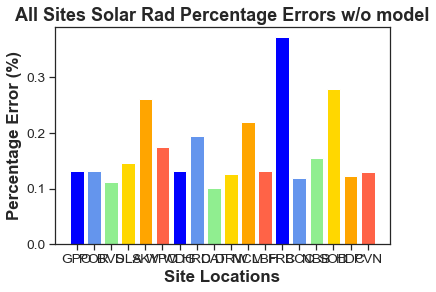

Where PE = |(M-A)/A|*100, the errors are: [0.13 0.13 0.11 0.15 0.26 0.18 0.13 0.19 0.10 0.13 0.22 0.13 0.37 0.12
 0.15 0.28 0.12 0.13]


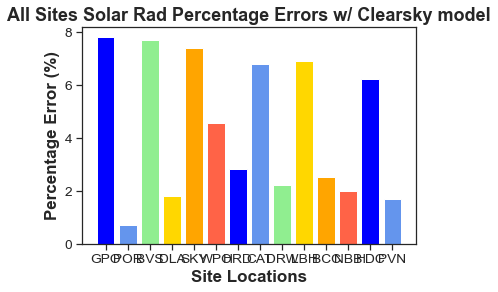

Where PE = |(M-A)/A|*100, the errors are: [7.81 0.71 7.71 1.81 7.39 4.59 2.84 6.81 2.22 6.91 2.53 2.03 6.23 1.73]
At ['WDG' 'NCM' 'FRC' 'SOD'], these percentage values were anomalous to the other days:[52.91 54.75 62.44 55.19]


In [67]:
plotALL(allmeans, ' w/o model')
plotALL(mallmeans, ' w/ Clearsky model')

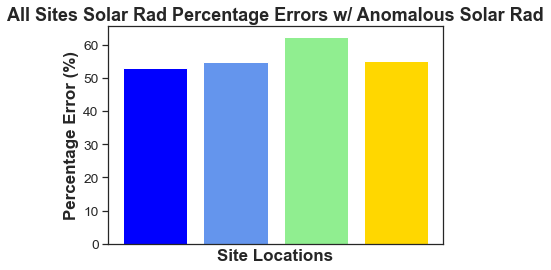

Where PE = |(M-A)/A|*100, the errors are: [52.91 54.75 62.44 55.19]
At ['WDG' 'NCM' 'FRC' 'SOD'], these percentage values were anomalous to the other days:[52.91 54.75 62.44 55.19]


In [68]:
anomaly = [windm, cowm, featm, sevm]
anom(anomaly, ' w/ Anomalous Solar Rad')

In [69]:
for i in range(len(hrdx)):
    print(str(hrdx[i].index.date[0]))

2022-04-05
2022-04-06
2022-04-08
2022-04-09
2022-04-12
2022-04-17
2022-04-23
2022-04-28
2022-05-01
2022-05-03
2022-05-04


In [70]:
hrd4y      = mets[8]['2022-04-12 13:00':'2022-04-13 03:00']
hrd8y      = mets[8]['2022-05-01 13:00':'2022-05-02 03:00']

hrdy = [hrd0, hrd1, hrd2, hrd3, hrd4y, hrd5, hrd6, hrd7, hrd8y, hrd9, hrd10]

allsitesy = ()
allsets = ()
allsitesy = (gpox, porx, bvsx, dlax, skyx, wpox, wdgx, hrdy, catx, drwx, ncmx, lbhx, frcx, \
            bccx, nbbx, sodx, hdcx, pvnx)

In [71]:
import matplotlib.dates as mdates

def allday(site, loc):
    times = pd.date_range('2015-05-01 06:00', periods = 421, freq = '2T')

    plt.rcParams["figure.figsize"] = [20.00, 8.0]
    plt.rcParams["figure.autolayout"] = True
    fig, ax = plt.subplots(1)
    fig.autofmt_xdate()
    for i in range(len(site)): 
        plt.plot(times, site[i][sr])
    plt.xlabel('Time of Day (PDT)', fontweight = 'bold', fontsize = 16)
    plt.ylabel('Solar Radiation (W/m\N{superscript two})', fontweight = 'bold', fontsize = 16)
    xfmt = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(xfmt)
    plt.title(str(loc)+' Solar Rad', fontweight = 'bold', fontsize = '20')
    plt.show()

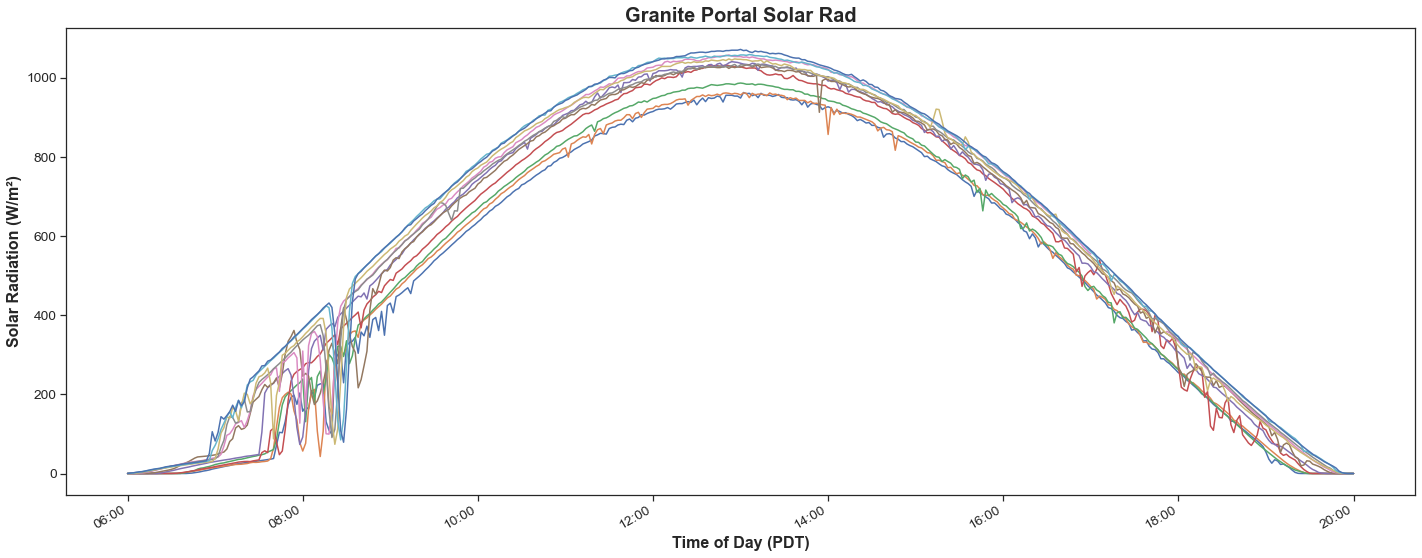

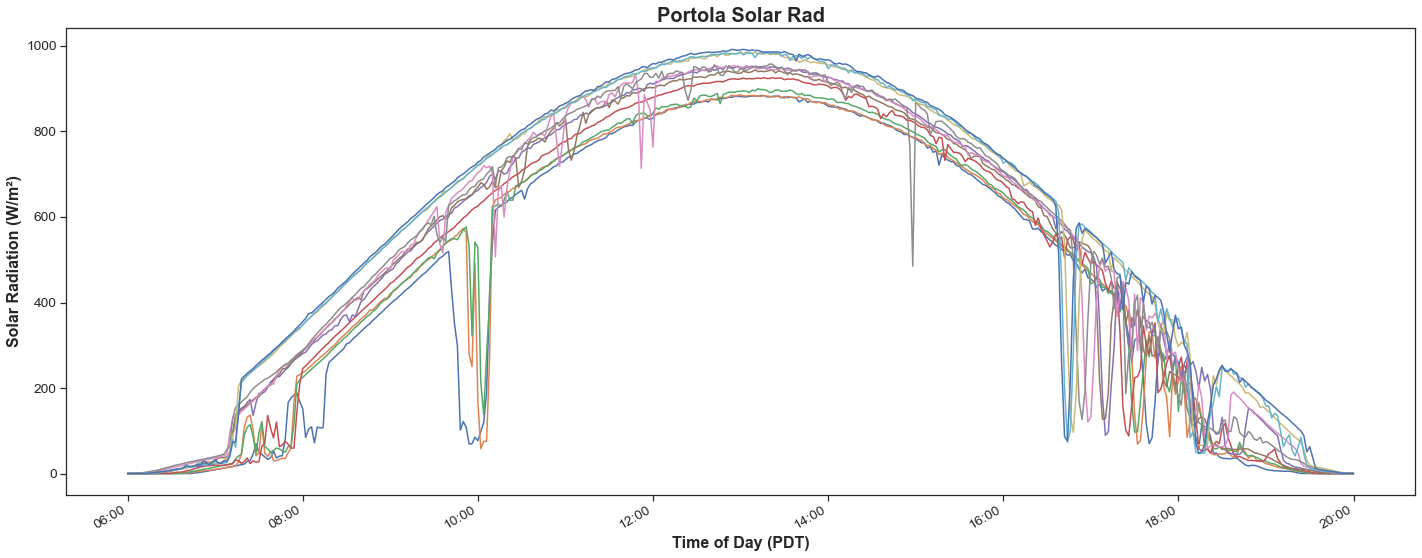

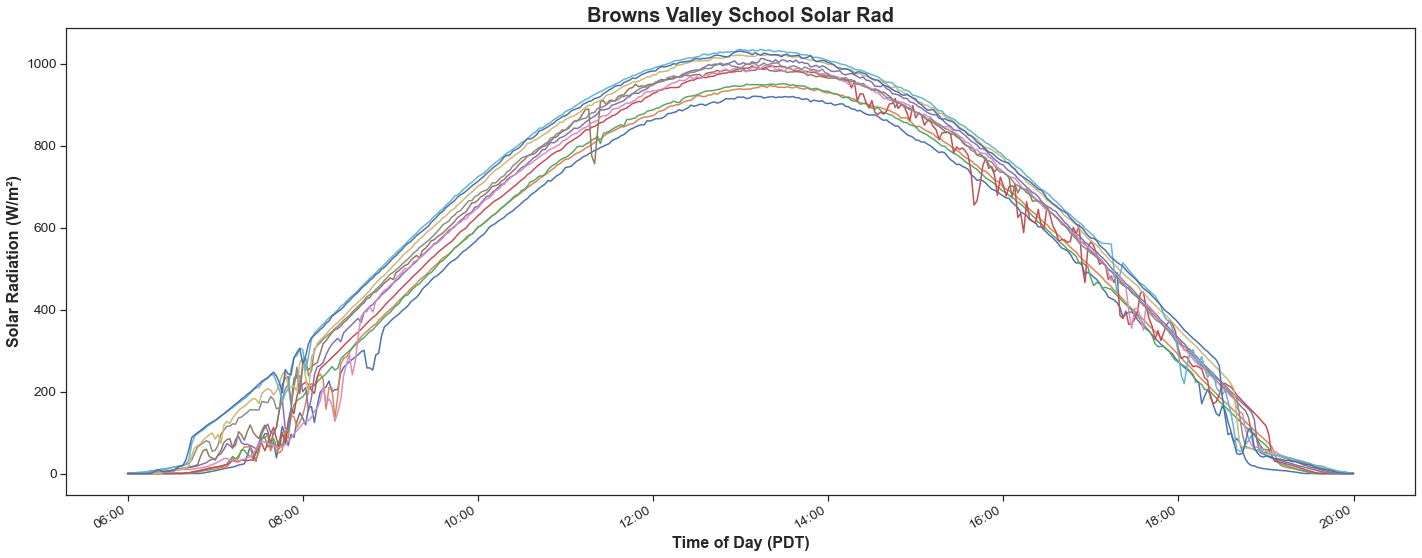

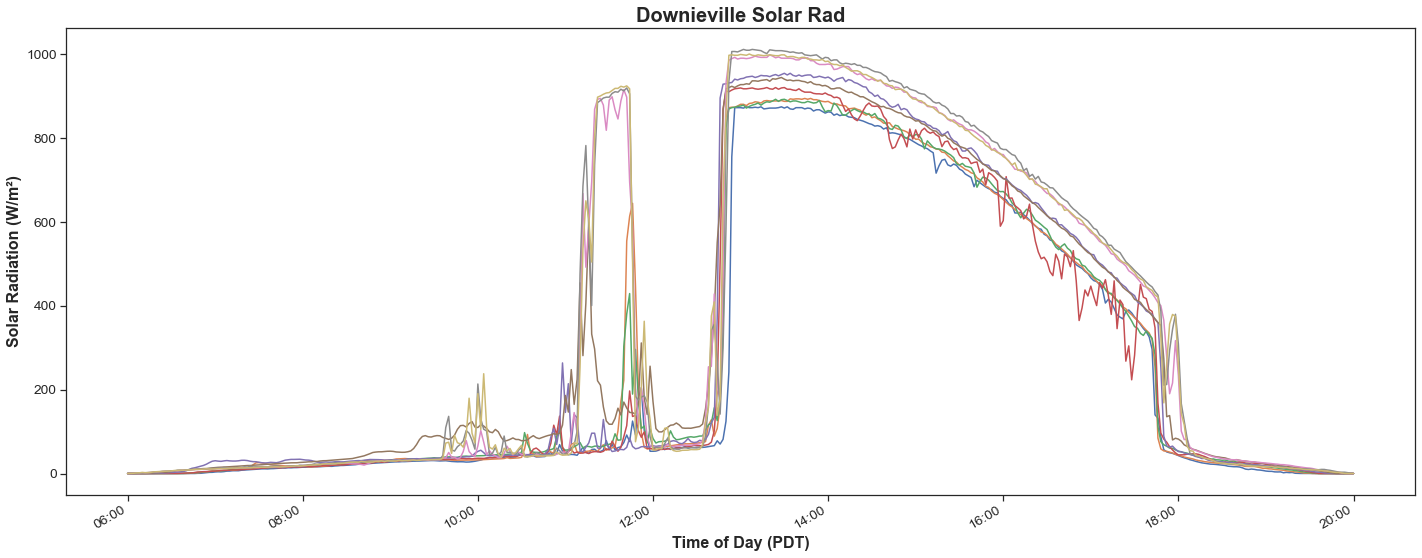

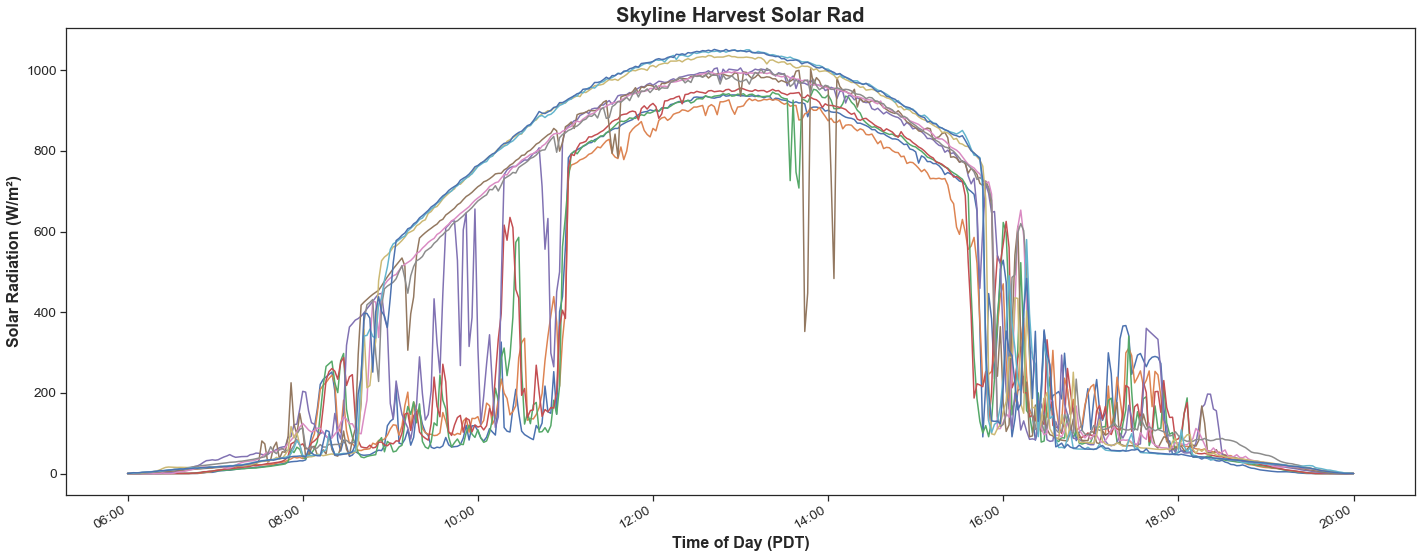

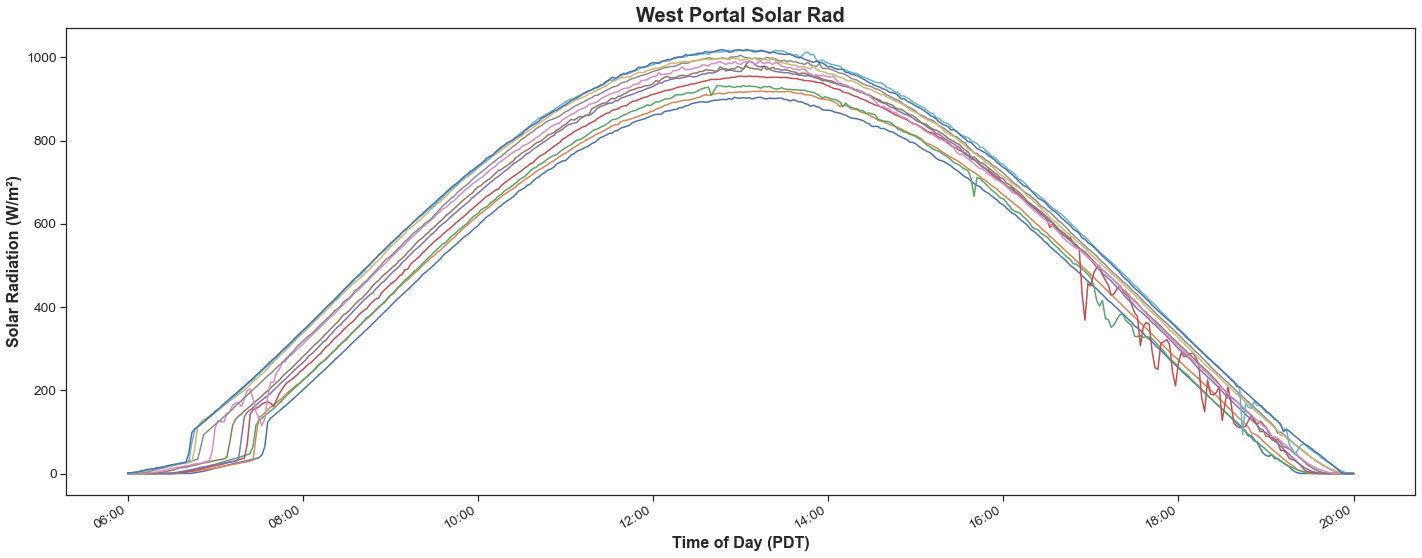

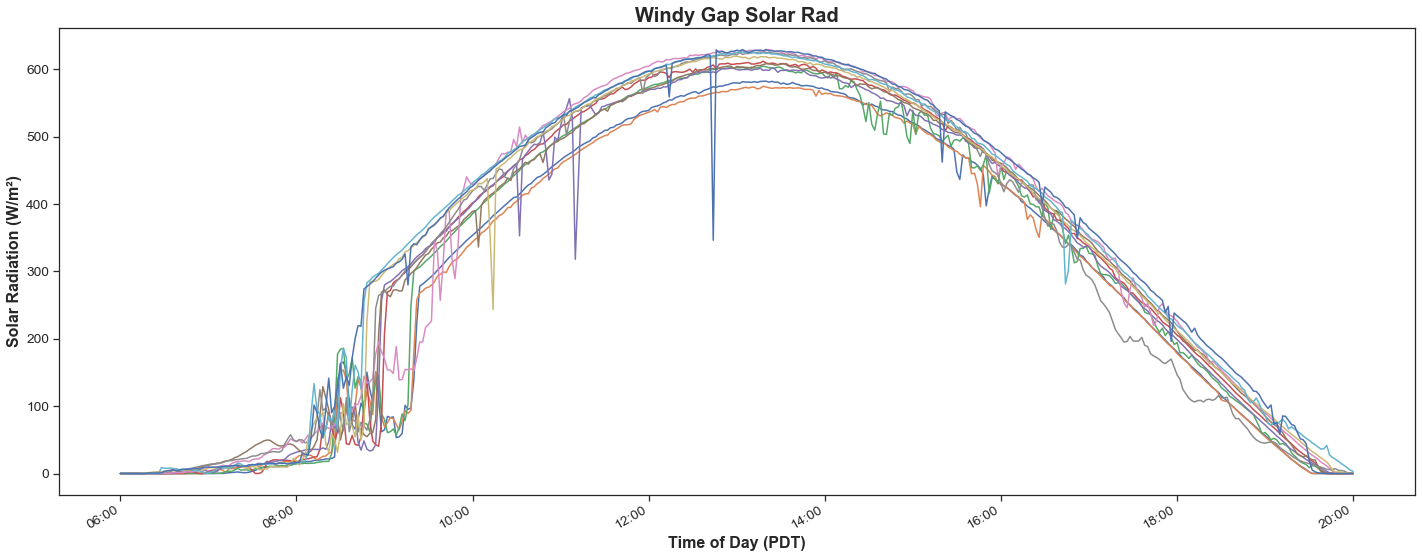

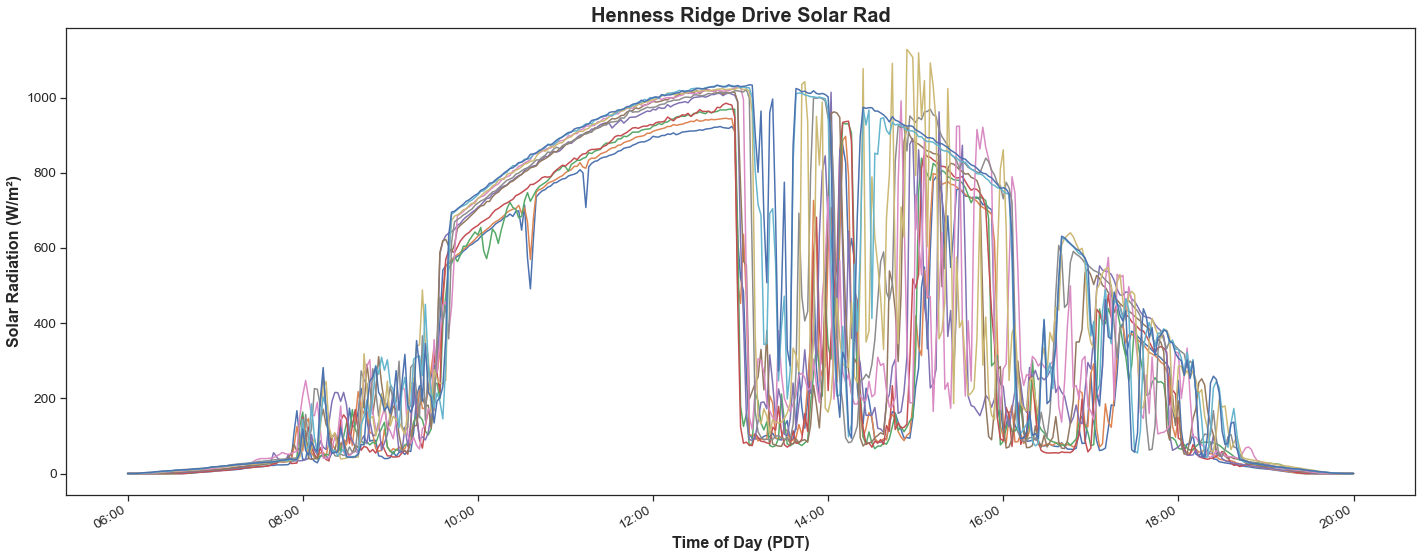

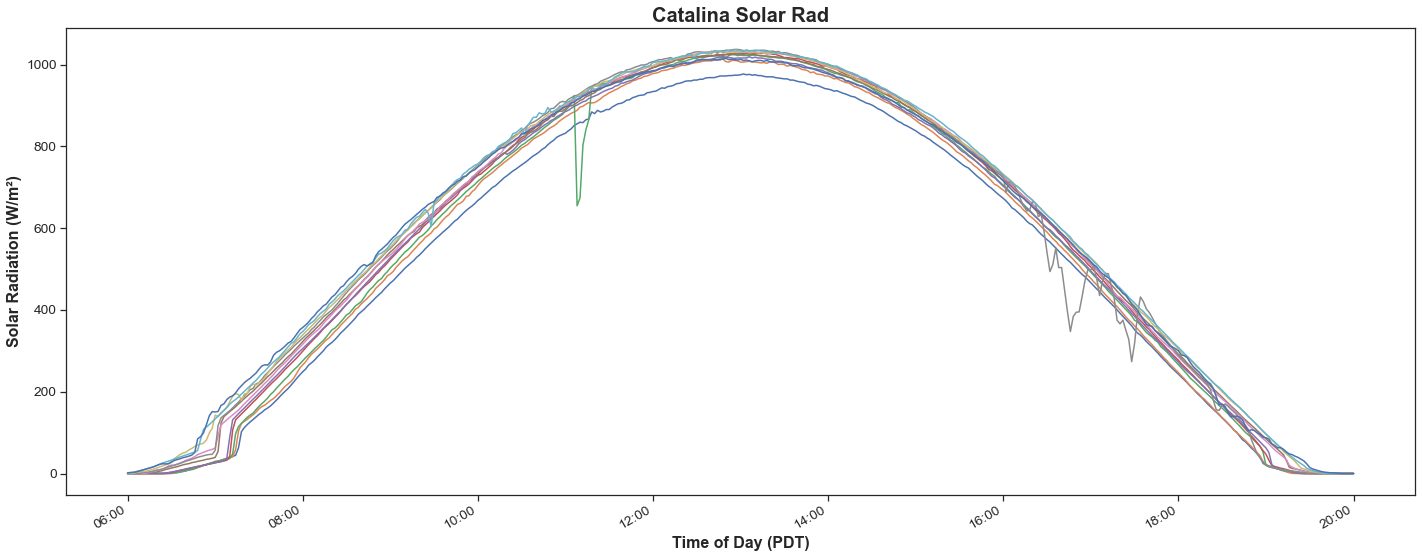

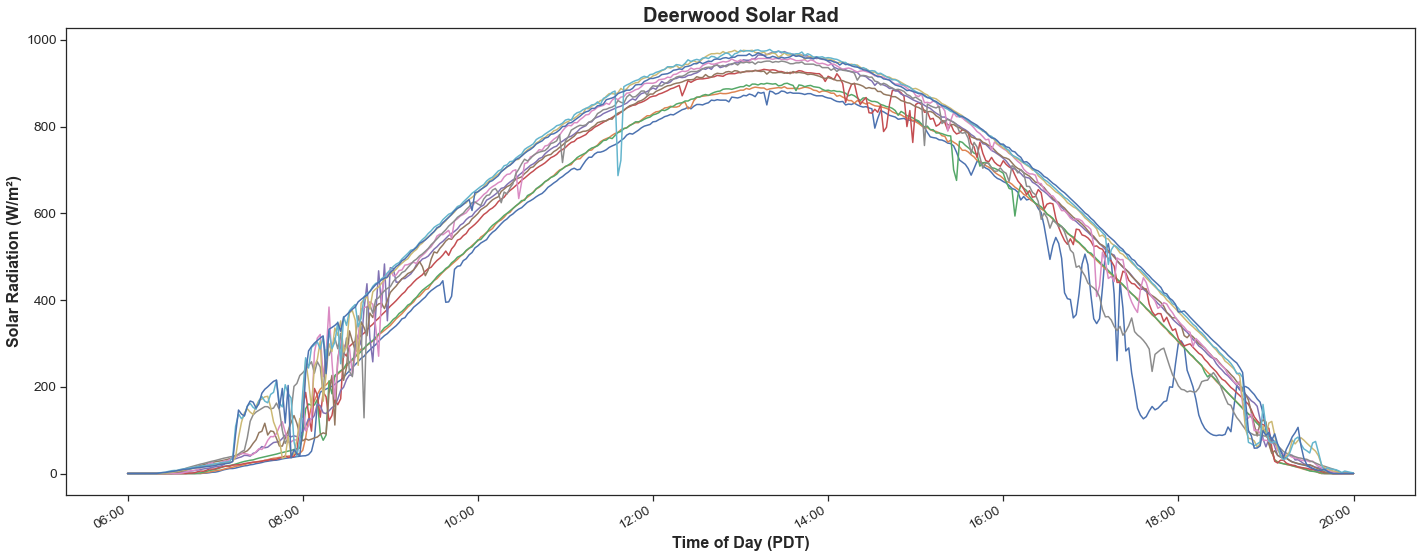

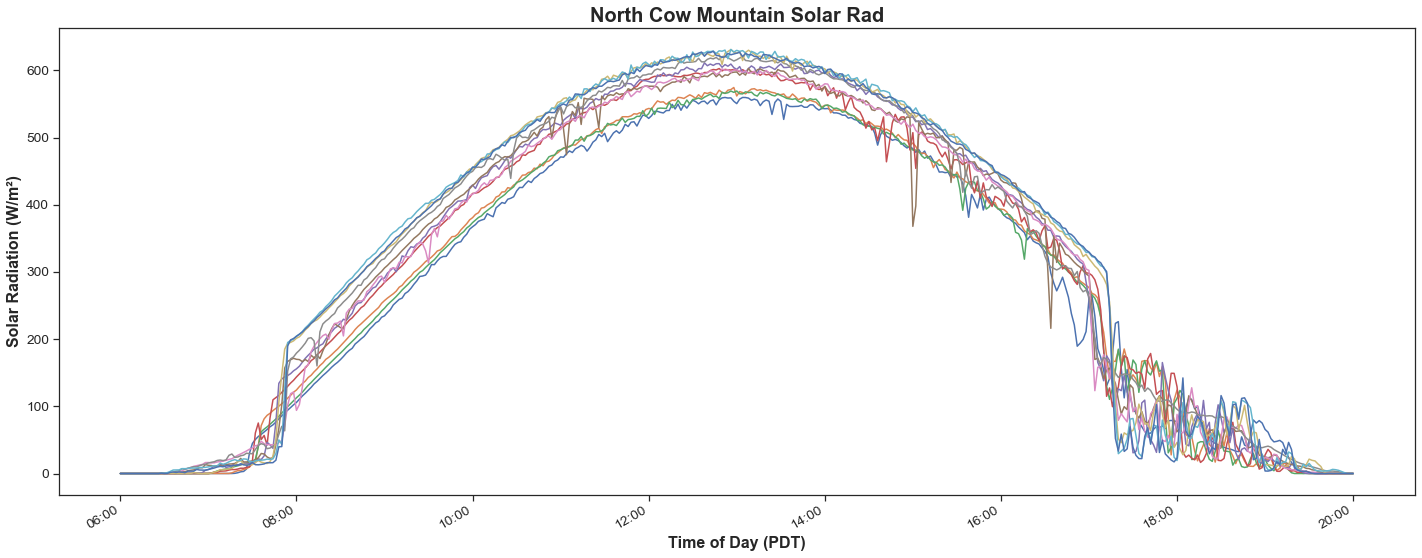

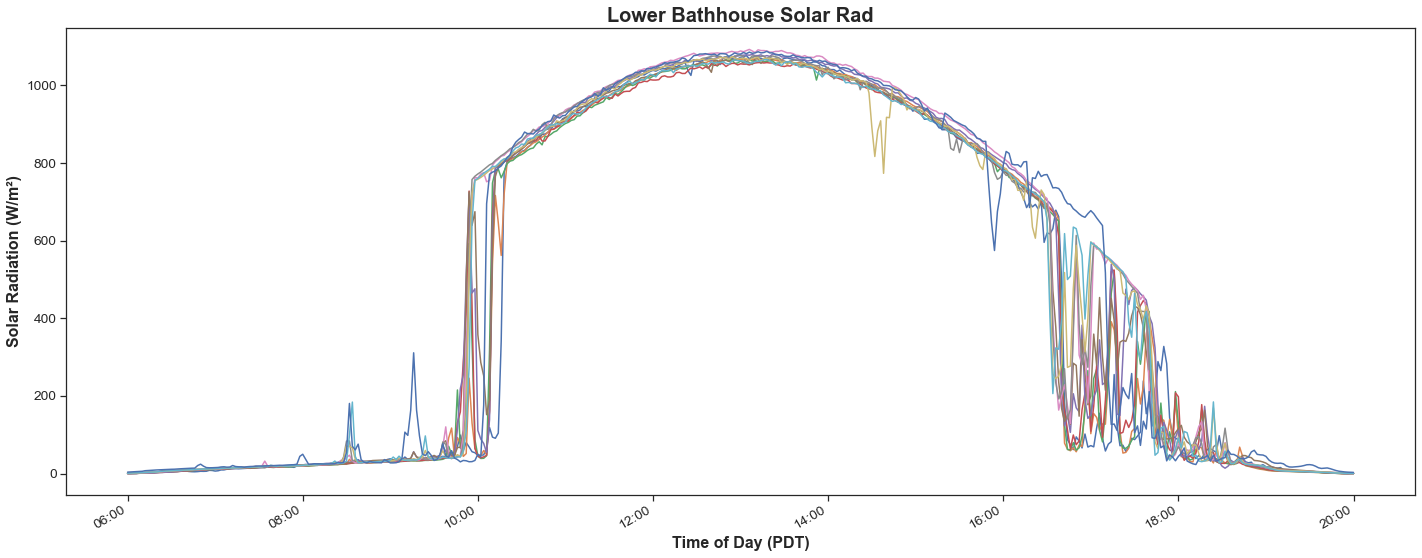

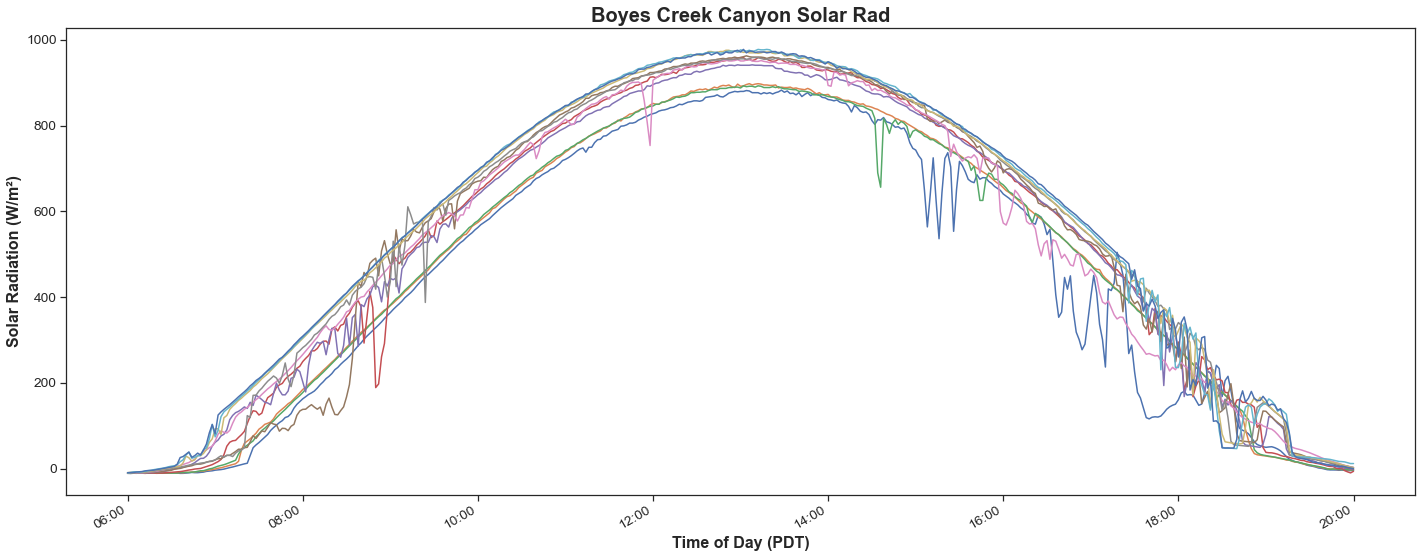

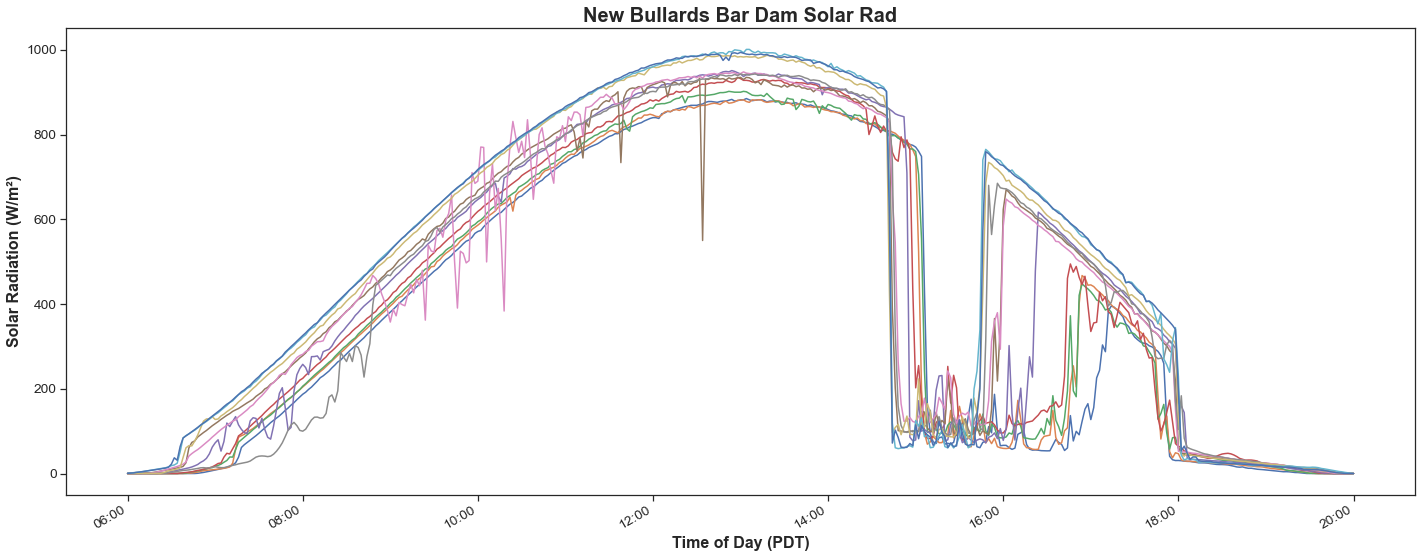

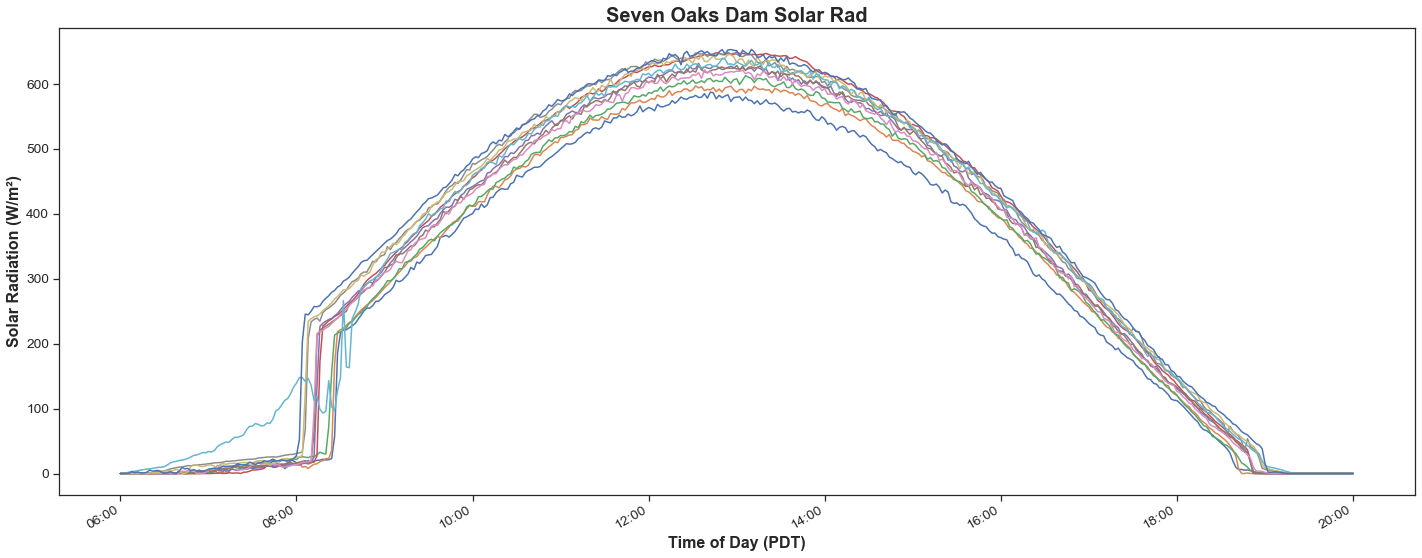

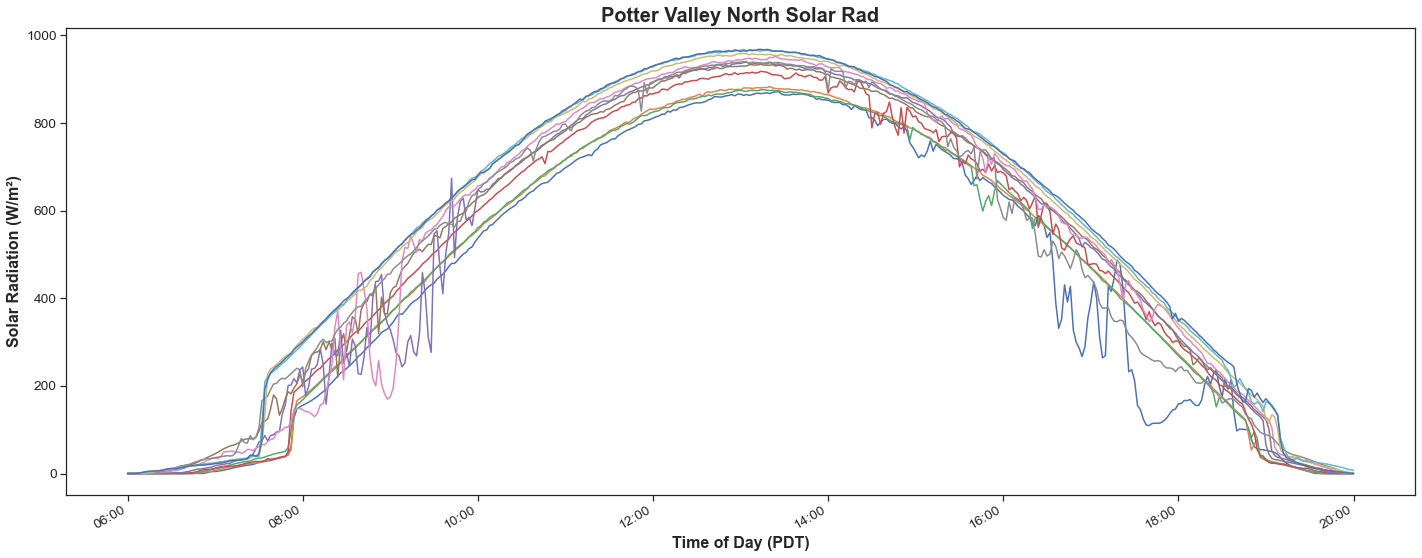

In [72]:
for i in range(len(allsites)):
    allday(allsitesy[i], allsitez[i][1])